# Preparations

In [3]:
from google.colab import drive, files
import pandas as pd
import numpy as np
from scipy import stats

#Preprocessing
from scipy.stats import pearsonr, mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

#Models
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans

#plots
import seaborn as sns
from matplotlib import pyplot as plt

#random state
randState = 0

#connect to googlee drive, might need adjustment to personal drive/folder structure
drive.mount('/content/drive')
path1 = "/content/drive/My Drive/dataset/Suhaib/" #path to dataset folder, each questionnaire is included here as a subfolder
# path1 = '/content/drive/My Drive/spring_2021/questionaire_project/google_collab/dataset/Suhaib/' # this link is for Huy to use

#functions to chose data set and embeddings type:

# Choose data set
def chooseData(data = "BIG5"): #choose big5 or ipip ### dataset paths   
  folder = data.upper() + "/"
  data = data.lower() + "_"
  return folder, data

#Choose embeddings type
def chooseEmb(emb = "USE"): #choose big5 or ipip ### dataset paths   
  embeddings = "questions_embeddings_" + emb.upper() +  ".csv"
  save = "_" + emb.upper() +  ".csv"
  return embeddings, save

#choose prediction model
def predModel(nr=1,par=1):
  if nr == 1:
    model = RidgeClassifier(alpha=par, random_state=randState)
    modName = "RidgeClass"
  elif nr==2:  
    model = KNeighborsClassifier(n_neighbors=par)
    modName = "KNN"
  elif nr==3:
    model = SVC(C=par, random_state=randState)
    modName = "SVC"
  elif nr==4:  
    model = KNeighborsRegressor(n_neighbors=par)
    modName = "KnnReg"
  elif nr == 0:
    model = Ridge(alpha=par, random_state=randState)
    modName = "Ridge"
  print("running {}: ".format(modName))
  return model, modName 

#choose reversed or non reversed data
def getResponses(path1, folder, data, R=1):
  if R == 1:
    res = "responses.csv"
    responses = pd.read_csv(path1+folder+data+res, index_col=0).T #reversed
    savePath = path1+folder+"new_results/by_embeddings/reversed/"
    items_ids = responses.columns
    items = responses.iloc[0,:].values
    if "item" in responses or "item" in responses.index:
      responses = responses.drop(["item"], axis=0)
  else:
    res = "responses_nonReversed.csv"
    responses = pd.read_csv(path1+folder+data+res, index_col=0).T #reversed
    responses.columns.name = ""
    savePath = path1+folder+"new_results/by_embeddings/nonReversed/"
    items_ids = responses.columns
    items = responses.iloc[0,:].values
    if "item" in responses or "item" in responses.index:
      responses = responses.drop(["item"], axis=0)

  return responses.astype(float), savePath, items, items_ids 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Accuracy functions

In [ ]:
def correlate(x,y): #pooled items performance
  corr_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  l1_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  questions = x.columns

  for i,nr in zip(constructs_list,range(len(constructs_list))): #go through constructs
    #find questions of current construct
    constrValues = constrAssigned.loc[questions].construct.values       #order the construct lists in the same order as responses/predictions
    constr_idx = np.where(constrValues == i)[0]  
    y_pred_constr = x.iloc[:,constr_idx]   #get predictions
    y_test_constr = y.loc[y_pred_constr.index,questions[constr_idx]]    #get label
    y_pred_match = y_pred_constr.values.flatten('F') #convert to 1D array
    y_test_match = y_test_constr.values.flatten('F')
    y_pred_match = y_pred_match[~pd.isnull(y_test_match)] #drop nan values, important for IPIP
    y_test_match = y_test_match[~pd.isnull(y_test_match)]

    #calculate correlation
    corr = np.round(pearsonr(y_pred_match,y_test_match),2)
    corr_constr.iloc[:,nr] = corr[0]
    l1 = np.round(sum(np.abs(y_pred_match-y_test_match))/len(y_test_match),2)
    l1_constr.iloc[:,nr] = l1

  y_pred = x.values.flatten()
  y_test = y.loc[y_pred_constr.index,:].values.flatten()
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]

  corr_total, pval_total = np.round(pearsonr(y_pred,y_test),3)
  l1_total = np.round(sum(np.abs(y_pred-y_test))/len(y_test),3)
  return list(corr_constr.mean()), corr_total, pval_total, list(l1_constr.mean()), l1_total

def corrUserBased(x,y):
  #calculate correlations and p value for every person, then average:
  results = pd.DataFrame(np.full(shape=(x.shape[0],3),fill_value=0),index = x.index,columns=["Correlation","p-value","L1 Loss"])
  
  #new function, much faster, #NOT FOR IPIP, #adjust for p value of averages
  corrVals = x.corrwith(y, 1, method=lambda x, y: np.round(pearsonr(x, y), 6)).fillna(0)
  results.iloc[:,:2] = corrVals.values.tolist()
  results.iloc[:,2] = np.absolute(x - y).sum(1)/x.shape[1] 
  results = results.fillna(0)
  t, pval_total = stats.ttest_1samp(results.Correlation, popmean=0) #get p-value of average correlation tested against 0, #change to make n decimals!
  return results, [results.Correlation.mean(), pval_total, results['L1 Loss'].mean()]

def corrAggregateScores(x,y): 
  #calculate correlations and p value for average user response:
  results = pd.DataFrame(np.full(shape=(constructs_list.shape[0],3),fill_value=0),index = constructs_list.tolist(), columns=["Correlation","p-value","L1 Loss"])
  questions = x.columns

  for i,nr in zip(constructs_list,range(len(constructs_list))): #go through constructs
      #labels and predictions for current construct 
      #find questions of current construct
    constrValues = constrAssigned.loc[questions].construct.values       #order the construct lists in the same order as responses/predictions
    constr_idx = np.where(constrValues == i)[0]  
    A = x.iloc[:,constr_idx].mean(1)
    B = y.iloc[:,constr_idx].mean(1)
    corr,pval = pearsonr(A,B)
    L1 = sum(np.absolute(A - B))/A.shape[0]
    results.iloc[nr] = np.array([corr,pval,L1]) 
  results = results.fillna(0)
  t, pval_total = stats.ttest_1samp(results.Correlation, popmean=0) #get p-value of average correlation tested against 0
  return results, [results.Correlation.mean(), pval_total, results['L1 Loss']] #add p value of average corr

def corrQuestionBased(x,y):
  #calculate correlations and p value for every question, then average:
  results = pd.DataFrame(np.full(shape=(x.shape[1],3),fill_value=0), index = x.columns,columns=["Correlation","p-value","L1 Loss"])
  questions = x.columns

  #get correlation across participants for each question
  for i in range(x.shape[1]):
    A = x.loc[~pd.isnull(y.iloc[:,i]), x.columns[i]] #predicted responses for question "i" over all participants who answered said question
    B = y.loc[~pd.isnull(y.iloc[:,i]), y.columns[i]] #actual    responses for question "i" over all participants who answered said question
    corr,pval = pearsonr(A,B)
    L1 = sum(np.absolute(A - B))/A.shape[0]
    results.iloc[i] = np.array([corr,pval,L1]) 
  results = results.fillna(0)
  t, pval_total = stats.ttest_1samp(results.Correlation, popmean=0) #get p-value of average correlation tested against 0
  return results, [results.Correlation.mean(), pval_total, results['L1 Loss']] #add p value of average corr

# accuracy (percentage of correct classifications)
def accuracy_constr(x,y, constructs_list): #do we report the construct wise accuracy? we could otherwise use a heatmap!
  metric_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  questions = x.index

  y_pred = x.values.flatten()
  y_test = y.loc[questions,:].values.flatten()
  y_test = y_test[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]
  metric_total = np.round(sum(y_pred==y_test)/len(y_test),3)
  return metric_total #list(metric_constr.mean()), metric_total

def accuracy_keys(x,y, constructs_list):
  metric_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  questions = x.index

  y_pred = x.values.flatten()
  y_test = y.loc[questions].values.flatten()
  y_test = y_test[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]
  metric_total = np.round(sum(y_pred==y_test)/len(y_test),3)
  return metric_total

### Import functions: embeddings & response data

In [ ]:
def getEmbeddings(folder, data, embeddings):
  #read in embeddings, order them like the response data and save in vector
  embeddings_df = pd.read_csv(path1 + folder + data +  embeddings,index_col=0)
  question_ids = responses.columns  #get IDs of questions answered

  # only get embeddings of questions having answers in matrix
  embeddings_df = embeddings_df.loc[question_ids,:]
  # save to vector 
  X = embeddings_df.values

  ################################ Preprocess input data::
  #Standardize for regression (wihtout PCA)
  X_stand = pd.DataFrame(StandardScaler().fit_transform(X),index=question_ids) #standardize embeddings
  #With PCA, for regression, 90% variance explained
  X_pca = pd.DataFrame(PCA(0.9, random_state=0).fit_transform(X_stand),index=question_ids) 

  return embeddings_df, X_stand, X_pca

def getData(m):
  
  question_ids = responses.columns
  data_q = X_pca_stand
  
  #choose parameter range
  if m==2 or m==4:  #KNN and KNN Regression
    list_par = [1,5,10,15,30,50] #parameter search
  elif m>=4:  #Random forest, extreme forest, gaussian
    list_par = [data_q.shape[1]] #parameter search
  else:  #Ridge, SVC
    list_par = [10**x for x in range(6)] #parameter search

  constructs = pd.read_csv(path1 + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
  constrAssigned = constructs.loc[data_q.index,:] #only take constructs/encodings of items with embeddings
  constructs_list = constrAssigned.construct.drop_duplicates().values
  data_q = data_q.loc[constrAssigned.index,:] #only keep items that have an assigned construct

  return data_q, constructs_list, list_par, constrAssigned

# Predictions

## Predict responses

### Hyperparameter search

In [ ]:
for l in ['sentencebert']: #go through the three embeddings, HSQ and HEXACO don't have SBERT embeddings
  for k in range(5):                       #calculate for each prediction model
    for j in range(2,3):                   #1: reversed, #2: nonReversed, RiASEC has only (j=2), IPIP with all items has only (j=2)

      # #model:
      m = k           #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
      #data:
      R = j           #1: reversed-coded, #2: nonReversed-coded

      ############################ choose output here ##############################
      d = "big5"       #data set   # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
      e = l
      corrMode = 2      #1: pooled items performance,  #2: user averaged, #3: question averaged #5: construct scores (e.g. OCEAN Scores)
      printAllCorrs = 0 #1: yes,  #0: no
      #####################################################################################

      #choose data set, embeddings, encoding
      folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
      embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
      responses, savePath, items, _ = getResponses(path1, folder, data, R) #1: Reversed, #2: nonReversed
      X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

      #get embeddings name:
      embName = embeddings.split("_")[2].split(".")[0]

      # import required data and labels
      data_q, constructs_list, list_par, constrAssigned = getData(m)

      ############################## 10-Fold cross validation:
      #Split dataframe 10 fold
      kf = KFold(n_splits=10, random_state=randState, shuffle=True)
      questions = list(kf.split(data_q))

      #get ids
      question_ids = responses.columns  #get IDs of questions answered
      user_ids = responses.index        #get IDs of users

      #initialise parameters:
      old_corr = -100
      acc_old = -1
      ##################################### predictions #####################################

      for par in list_par:

        model, modelName = predModel(m,par) 
        #Dataframes to store all predictions
        total_preds = pd.DataFrame(np.full(responses.shape, np.nan), columns=question_ids, index=user_ids)
        total_dumb = pd.DataFrame(np.full(responses.shape, np.nan), columns=question_ids, index=user_ids)     #dumb predictor individual level

        for q_fold, fold_nr in zip(questions,range(len(questions))): #go through the question folds
          #print("Fold {}:".format(str(fold_nr + 1))) #status/progress
          
          #train/test index and embeddings for current fold
          qid_train = q_fold[0]
          qid_test = q_fold[1]
          q_test = data_q.iloc[qid_test]

          # (train:) for each userfold go through all questions of the question fold and concatenate question embedding to all users
          for user,y in enumerate(responses.values):
            
            q_train = data_q.iloc[qid_train]
            #get responses for ith user on the training questions
            y_train = y[qid_train]
            q_train = q_train.loc[~pd.isnull(y_train),:]
            y_train = y_train[~pd.isnull(y_train)].astype('int')

            if (m==3) & (len(set(y_train)) == 1): #if only one type of response in training fold, use value for prediction (because SVC does not work with only one class)
              y_pred = np.repeat(y_train[0],q_test.shape[0])
            else: 
              y_pred = np.round(model.fit(q_train,y_train).predict(q_test),0)

            y_pred[y_pred < 1] = 1
            y_pred[y_pred > 5] = 5

            #Dumb predictor uses mode of training data to predict the fold
            if data[:-1] == "npi": #for classification of the NPI data set
              y_dumb = np.repeat(mode(y)[0],q_test.shape[0])
            else: #all others
              y_dumb = np.repeat(np.round(np.mean(y_train),0),q_test.shape[0]) 

            #save predictions in in dataframe
            total_preds.iloc[user, qid_test] = y_pred
            total_dumb.iloc[user, qid_test] = y_dumb

        #Model metrics:
        print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":") #hand over string with specs...

        # #calculate model metrics:
        if corrMode == 1 or printAllCorrs == 1:
          corr_constr, corr, pval, l1_constr, l1 = correlate(total_preds, responses)
          #DUMB:
          corr_constr_DUMB, corr_dumb, pval_dumb, l1_constr_DUMB, l1_dumb = correlate(total_dumb, responses)

          model_tag = modelName + " (N=" + str(par) + ")"
          #additional information when all metrics are print out together
          if printAllCorrs == 1:
            print("pooled:")
            print([round(corr,3), round(l1,3), round(pval,3)])

        if corrMode == 2 or printAllCorrs == 1:
          results, resultsMean = corrUserBased(total_preds, responses)
          corr, pval, l1 = resultsMean

          model_tag = modelName + " (N=" + str(par) + ")"
          #DUMB:
          results_dumb, resultsMean_dumb = corrUserBased(total_dumb, responses)
          corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
          #additional information when all metrics are print out together
          if printAllCorrs == 1:
            print("user based:")
            print([round(corr,3), round(l1,3), round(pval,3)])

        if corrMode == 3 or printAllCorrs == 1:
          results, resultsMean = corrQuestionBased(total_preds, responses)
          corr, pval, l1 = resultsMean

          model_tag = modelName + " (N=" + str(par) + ")"
          #DUMB:
          results_dumb, resultsMean_dumb = corrQuestionBased(total_dumb, responses)
          corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
          #additional information when all metrics are print out together
          if printAllCorrs == 1:
            print("question based:")
            print([round(corr,3), round(l1,3), round(pval,3)])

        if corrMode == 4 or printAllCorrs == 1:
          results, resultsMean = corrAggregateScores(total_preds, responses)
          corr, pval, l1 = resultsMean

          model_tag = modelName + " (N=" + str(par) + ")"
          #DUMB:
          results_dumb, resultsMean_dumb = corrAggregateScores(total_dumb, responses)
          corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
          #additional information when all metrics are print out together
          if printAllCorrs == 1:
            print("aggregated:")
            print([round(corr,3), round(l1,3), round(pval,3)])

        if printAllCorrs != 1:
          print([round(corr,3), round(l1,3), round(pval,3)])
          print("\n")
          if corrMode == 1:
            print("Correlation across all folds, by construct: \n", corr_constr)
            # print("L1-Loss across all folds, by construct: \n", l1_constr)
            print("\n")
            pass
            
        # total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv") #save predictions -> to calculate and predict performance for plots

        #stop search after maximum
        new_corr = corr
        if new_corr < old_corr:
          break
        else:
          old_corr = new_corr 

running Ridge: 
MODEL: Ridge (par = 1) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.376, 1.063, 0.0]


running Ridge: 
MODEL: Ridge (par = 10) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.38, 1.055, 0.0]


running Ridge: 
MODEL: Ridge (par = 100) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.407, 0.996, 0.0]


running Ridge: 
MODEL: Ridge (par = 1000) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.445, 0.913, 0.0]


running Ridge: 
MODEL: Ridge (par = 10000) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.266, 1.045, 0.0]


running RidgeClass: 
MODEL: RidgeClass (par = 1) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.335, 1.074, 0.0]


running RidgeClass: 
MODEL: RidgeClass (par = 10) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.339, 1.07, 0.0]


running RidgeClass: 
MODEL: RidgeClass (par = 100) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.366, 1.036, 0.0]


running RidgeClass: 
MODEL: RidgeClass (par = 1000) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.413, 0.965, 0.0]


running RidgeClass: 
MODEL: RidgeClass (par = 10000) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.347, 1.004, 0.0]


running KNN: 
MODEL: KNN (par = 1) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.373, 1.033, 0.0]


running KNN: 
MODEL: KNN (par = 5) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.408, 0.998, 0.0]


running KNN: 
MODEL: KNN (par = 10) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.377, 1.02, 0.0]


running SVC: 
MODEL: SVC (par = 1) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.405, 0.946, 0.0]


running SVC: 
MODEL: SVC (par = 10) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.434, 0.942, 0.0]


running SVC: 
MODEL: SVC (par = 100) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.432, 0.945, 0.0]


running KnnReg: 
MODEL: KnnReg (par = 1) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.373, 1.033, 0.0]


running KnnReg: 
MODEL: KnnReg (par = 5) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.453, 0.902, 0.0]


running KnnReg: 
MODEL: KnnReg (par = 10) SENTENCEBERT:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.418, 0.934, 0.0]




DUMB/Baseline Metrics

Baseline defined as averaged response in the training fold

In [ ]:
# print out DUMB metrics
print("Correct DUMB correlation across all folds: ", np.round(corr_dumb,3))
print("\n")
print("Correct DUMB l1-loss across all folds: ", np.round(l1_dumb,3))
print("\n")
if corrMode != 1:
  print("Correct DUMB l1-loss across all folds: ", np.round(pval_dumb,3))
  print("\n")

### Single predictions

In [ ]:
# #model:
m =   4             #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN Regression
par = 5
corrMode = 2        #1: total, #2: userBased, #3: questionBased, #4: average construct scores (OCEAN Scores)
printAllCorrs = 0

#data:
R = 2               #1: reversed, #2: nonReversed, RiASEC has only (j=2), IPIP with all items has only (j=2)
d = "ipip"          #IPIP: all items, IPIP2: only assigned
e = "sentencebert"

#choose data set, embeddings, encoding
folder, data = chooseData(d)                                      # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)                                   # USE, BERT, SENTENCEBERT
responses, savePath, items,_ = getResponses(path1, folder, data, R) #1: Reversed, #2: nonReversed
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]
# import required data and labels
data_q, constructs_list, list_par, constrAssigned = getData(m)

############################## 10-Fold cross validation:
#Split dataframe 10 fold
kf = KFold(n_splits=10, random_state=randState, shuffle=True)
questions = list(kf.split(data_q))

#get ids
question_ids = responses.columns  #get IDs of questions answered
user_ids = responses.index        #get IDs of users

#################################### predictions #####################################

model, modelName = predModel(m,par) 
#Dataframes to store all predictions
total_preds = pd.DataFrame(np.full(responses.shape, np.nan), columns=question_ids, index=user_ids)
total_dumb = pd.DataFrame(np.full(responses.shape, np.nan), columns=question_ids, index=user_ids)     #dumb predictor individual level

for q_fold, fold_nr in zip(questions,range(len(questions))): #go through the question folds
  print("Fold {}:".format(str(fold_nr + 1))) #status/progress
  
  #train/test index and embeddings for current fold
  qid_train = q_fold[0]
  qid_test = q_fold[1]
  q_test = data_q.iloc[qid_test]

  # (train:) for each userfold go through all questions of the question fold and concatenate question embedding to all users
  for user,y in enumerate(responses.values):
    
    q_train = data_q.iloc[qid_train]
    #get responses for ith user on the training questions
    y_train = y[qid_train]
    q_train = q_train.loc[~pd.isnull(y_train),:]
    y_train = y_train[~pd.isnull(y_train)].astype('int')

    if (m==3) & (len(set(y_train)) == 1): #if only one type of response in training fold, use value for prediction (SVC does not work with only one class)
      y_pred = np.repeat(y_train[0],q_test.shape[0])
    else: 
      y_pred = np.round(model.fit(q_train,y_train).predict(q_test),0)

    y_pred[y_pred < 1] = 1
    y_pred[y_pred > 5] = 5
    y_dumb = np.repeat(np.round(np.mean(y_train),0),q_test.shape[0]) 

    #save predictions in in dataframe
    total_preds.iloc[user, qid_test] = y_pred
    total_dumb.iloc[user, qid_test] = y_dumb

# #calculate model metrics:
if corrMode == 1 or printAllCorrs == 1:
  corr_constr, corr, pval, l1_constr, l1 = correlate(total_preds, responses)
  #DUMB:
  corr_constr_DUMB, corr_dumb, pval_dumb, l1_constr_dumb, l1_dumb = correlate(total_dumb, responses)
  #additional information when all metrics are print out together
  if printAllCorrs == 1:
    print("pooled:")
    print([round(corr,3), round(l1,3), round(pval,3)])
if corrMode == 2 or printAllCorrs == 1:
  results, resultsMean = corrUserBased(total_preds, responses)
  corr, pval, l1 = resultsMean
  #DUMB:
  results_dumb, resultsMean_dumb = corrUserBased(total_dumb, responses)
  corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
  #additional information when all metrics are print out together
  if printAllCorrs == 1:
    print("user based:")
    print([round(corr,3), round(l1,3), round(pval,3)])

if corrMode == 3 or printAllCorrs == 1:
  results, resultsMean = corrQuestionBased(total_preds, responses)
  corr, pval, l1 = resultsMean
  #DUMB:
  results_dumb, resultsMean_dumb = corrQuestionBased(total_dumb, responses)
  corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
  #additional information when all metrics are print out together
  if printAllCorrs == 1:
    print("question based:")
    print([round(corr,3), round(l1,3), round(pval,3)])

if corrMode == 4 or printAllCorrs == 1:
  results, resultsMean = corrAggregateScores(total_preds, responses)
  corr, pval, l1 = resultsMean
  #DUMB:
  results_dumb, resultsMean_dumb = corrAggregateScores(total_dumb, responses)
  corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
  #additional information when all metrics are print out together
  if printAllCorrs == 1:
    print("aggregated:")
    print([round(corr,3), round(l1,3), round(pval,3)])

if printAllCorrs != 1:
  print([round(corr,3), round(l1,3), round(pval,3)])
  print("\n")
  if corrMode == 1:
    print("Correlation across all folds, by construct: \n", corr_constr)
    print("L1-Loss across all folds, by construct: \n", l1_constr)
    print("\n")

# total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv")
# total_dumb.to_csv(savePath + 'baseline' + "_responses.csv")

## Predict constructs

### Hyperparameter search

In [ ]:
for  l in ['use', 'bert', 'sentencebert']: #go through the three embeddings
  for k in range(1,4):                       #calculate for each prediction model

    ################################################ model:
    m = k                 #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
    ################################################ choose data:
    d = "hsq"            #data set, BIG5, IPIP2, RIASEC, 16PF, HSQ
    e =  l                #embeddings type: USE, BERT, SENTENCEBERT

    #import data set, embeddings, encoding
    folder, data = chooseData(d) 
    embeddings, save = chooseEmb(e) 
    responses, savePath, items = getResponses(path1, folder, data, 2) #1: Reversed, #2: nonReversed
    X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

    # #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]

    # import required data and labels
    data_q, constructs_list, list_par, constrAssigned = getData(m)
    y_constr = constrAssigned.construct.values #get construct values
    #dicts to convert number to constructs and vice versa
    constrNr = {f: n for n, f in enumerate(constructs_list, 1)} #change construct name to integer for the prediction models
    y = pd.DataFrame(np.asarray((list(map(constrNr.get, y_constr)))), index= constrAssigned.index, columns=["constructs"]) #list of labels converted to numbers (1 to n)

    ##################################### predictions #####################################
    question_ids = data_q.index  #get IDs of questions answered

    #initialise parameters:
    old_acc = -100
    kf_constr = KFold(n_splits=10, random_state=randState, shuffle=True) #10-Fold cross validation
    questions_constr = list(kf_constr.split(data_q))

    for par in list_par:
      model, modelName = predModel(m,par)  #model = LogisticRegression(C = par), 
      #Dataframes to store all predictions
      total_preds = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["constructs"], index=question_ids)
      total_dumb = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["constructs"], index=question_ids)     #dumb predictor individual level

      for q_fold, fold_nr in zip(questions_constr,range(len(questions_constr))): #go through the question folds      
        #train/test index and embeddings for current fold
        qid_train = q_fold[0]
        qid_test = q_fold[1]
        q_train = data_q.iloc[qid_train]
        q_test = data_q.iloc[qid_test]

        y_train = y.loc[q_train.index].values.flatten()
        y_pred  = np.round(model.fit(q_train, y_train).predict(q_test),0)
        #Dumb predictor uses mode of training data to predict the fold
        y_dumb = np.repeat(mode(y)[0],q_test.shape[0])

        #save predictions in in dataframe
        total_preds.iloc[qid_test,0] = y_pred
        total_dumb.iloc[qid_test,0] = y_dumb

      #calculate model metrics:
      acc_total = accuracy_constr(total_preds, y) #correct classifications percentage
      #DUMB metrics:
      acc_dumb_total = accuracy_constr(total_dumb, y)  #correct dumb classifications percentage

      print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":") #hand over string with specs...
      print("Correct classifications across all folds: ", acc_total)
      print("Correct DUMB classifications across all folds: ", acc_dumb_total)
      print("\n")

      total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_constructs.csv")

      #stop search after maximum
      new_acc = acc_total
      if new_acc < old_acc:
        break
      else:
        old_acc = new_acc

### Single prediction

In [ ]:
################################################ model:
m = 1                 #0: KNN Reg, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 1000
################################################ choose data:
d = "ipip2"            #data set, BIG5, IPIP2, RIASEC, 16PF, HSQ
e = "liwc"    #embeddings type: USE, BERT, WORD2VEC, SENTENCEBERT

#import data set, embeddings, encoding
folder, data = chooseData(d) 
embeddings, save = chooseEmb(e) 
responses, savePath, items = getResponses(path1, folder, data, 2) #1: Reversed, #2: nonReversed
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

# #get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]
# import required data and labels
data_q, constructs_list, list_par, constrAssigned = getData(m)

y_constr = constrAssigned.construct.values #get construct values
#dicts to convert number to constructs and vice versa
constrNr = {f: n for n, f in enumerate(constructs_list, 1)} #change construct name to integer for the prediction models
y = pd.DataFrame(np.asarray((list(map(constrNr.get, y_constr)))), index= constrAssigned.index, columns=["constructs"]) #list of labels converted to numbers (1 to n)

##################################### predictions #####################################

question_ids = data_q.index  #get IDs of questions answered
kf_constr = KFold(n_splits=10, random_state=randState, shuffle=True) #10 Fold cross validation
questions_constr = list(kf_constr.split(data_q))

model, modelName = predModel(m,par)  #model = LogisticRegression(C = par), 
#Dataframes to store all predictions
total_preds = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["constructs"], index=question_ids)
total_dumb = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["constructs"], index=question_ids)     #dumb predictor individual level

for q_fold, fold_nr in zip(questions_constr,range(len(questions_constr))): #go through the question folds
  #train/test index and embeddings for current fold
  qid_train = q_fold[0]
  qid_test = q_fold[1]
  q_train = data_q.iloc[qid_train]
  q_test = data_q.iloc[qid_test]

  y_train = y.loc[q_train.index].values.flatten()
  y_pred  = np.round(model.fit(q_train, y_train).predict(q_test),0)
  #Dumb predictor uses mode of training data to predict the fold
  y_dumb = np.repeat(stats.mode(y.constructs)[0],q_test.shape[0])

  #save predictions in in dataframe
  total_preds.iloc[qid_test,0] = y_pred
  total_dumb.iloc[qid_test,0] = y_dumb

#calculate model metrics:
acc_total = accuracy_constr(total_preds, y) #correct classifications percentage
#DUMB metrics:
acc_dumb_total = accuracy_constr(total_dumb, y)  #correct dumb classifications percentage

print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":\n") #hand over string with specs...
print("Correct classifications across all folds: ", acc_total)
print("Correct DUMB classifications across all folds: ", acc_dumb_total)
print("\n")

# save predictions
# total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_constructs.csv")
# total_dumb.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_constructs_dumb.csv")

running RidgeClass: 
MODEL: RidgeClass (par = 1000) LIWC:

Correct classifications across all folds:  0.076
Correct DUMB classifications across all folds:  0.022




## Predict keys

### Hyperparameter search

In [ ]:
for  l in ['use', 'bert', 'sentencebert']:    #go through the three embeddings
  for k in range(1,4):                        #calculate for each prediction model
    m = k             #1: RidgeClass, #2: KNN, #3: Kernel SVM (RBF)

    #data:
    d = "hsq"         # BIG5, 16PF, HSQ 
    e = l        #Embeddings: USE, BERT, SENTENCEBERT

    #choose data set, embeddings, encoding
    folder, data = chooseData(d) 
    embeddings, save = chooseEmb(e) 
    responses, savePath, items = getResponses(path1, folder, data, 1) #1: Reversed, #2: nonReversed
    X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]

    # import required data and labels
    data_q, constructs_list, list_par, constrAssigned = getData(m)
    keys = constrAssigned.encoding.replace([-1,1],[1,0])

    ############################## 10-Fold cross validation:
    #Split dataframe 10 fold
    kf_constr = KFold(n_splits=responses.shape[1], random_state=randState, shuffle=True) #leave one out cross validation
    questions_constr = list(kf_constr.split(data_q))
    question_ids = data_q.index  #get IDs of questions answered

    #initialise parameters:
    old_acc = -100

    ##################################### predictions #####################################

    for par in list_par:
      model, modelName = predModel(m,par)

      #Dataframes to store all predictions
      total_preds = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["encoding"], index=question_ids)
      total_dumb = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["encoding"], index=question_ids)     #dumb predictor individual level

      for q_fold, fold_nr in zip(questions_constr,range(len(questions_constr))): #go through the question folds
        #print("Fold {}:".format(str(fold_nr + 1))) #status/progress
      
        #train/test index and embeddings for current fold
        qid_train = q_fold[0]
        qid_test = q_fold[1]
        idx = np.where(constrAssigned.construct[qid_test].values == constrAssigned.construct[qid_train].values)[0]
        qid_train_constr = qid_train[idx]
        q_train = data_q.iloc[qid_train_constr]
        q_test = data_q.iloc[qid_test]
        y_train = keys.loc[q_train.index].values.flatten()
        y_pred  = np.round(model.fit(q_train, y_train).predict(q_test),0)
        #Dumb predictor uses mode of training data to predict the fold
        y_dumb = np.repeat(mode(keys.values.flatten())[0],q_test.shape[0])

        #save predictions in in dataframe
        total_preds.iloc[qid_test,0] = y_pred
        total_dumb.iloc[qid_test,0] = y_dumb

      #calculate model metrics:
      acc_total = accuracy_keys(total_preds, keys) #correct classifications percentage
      #DUMB metrics:
      acc_dumb_total = accuracy_keys(total_dumb, keys)  #correct dumb classifications percentage

      print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":\n") #hand over string with specs...
      print("Correct classifications across all folds: ", acc_total)
      print("Correct DUMB classifications across all folds: ", acc_dumb_total)
      print("\n")

      # total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_encodings_constrBased.csv")

      #stop search after maximum
      new_acc = acc_total
      if new_acc < old_acc:
        break
      else:
        old_acc = new_acc

### Single prediction

In [ ]:
m = 1             #1: RidgeClass, #2: KNN, #3: Kernel SVM (RBF)
par = 10

#data:
d = "hsq"         # BIG5, 16PF, HSQ
e = 'liwc'        #Embeddings: USE, BERT, SENTENCEBERT

#choose data set, embeddings, encoding
folder, data = chooseData(d) 
embeddings, save = chooseEmb(e) 
responses, savePath, items = getResponses(path1, folder, data, 2) #1: Reversed, #2: nonReversed
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels
data_q, constructs_list, list_par, constrAssigned = getData(m)
keys = constrAssigned.encoding.replace([-1,1],[1,0])

############################## 10-Fold cross validation:
#Split dataframe 10 fold
kf_constr = KFold(n_splits=responses.shape[1], random_state=randState, shuffle=True) #leave one out cross validation
questions_constr = list(kf_constr.split(data_q))
question_ids = data_q.index  #get IDs of questions answered

#initialise parameters:
old_acc = -100

##################################### predictions #####################################

model, modelName = predModel(m,par)

#Dataframes to store all predictions
total_preds = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["encoding"], index=question_ids)
total_dumb = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["encoding"], index=question_ids)     #dumb predictor individual level

for q_fold, fold_nr in zip(questions_constr,range(len(questions_constr))): #go through the question folds

  #train/test index and embeddings for current fold
  qid_train = q_fold[0]
  qid_test = q_fold[1]
  idx = np.where(constrAssigned.construct[qid_test].values == constrAssigned.construct[qid_train].values)[0]
  qid_train_constr = qid_train[idx]
  q_train = data_q.iloc[qid_train_constr]
  q_test = data_q.iloc[qid_test]

  y_train = keys.loc[q_train.index].values.flatten()
  y_pred  = np.round(model.fit(q_train, y_train).predict(q_test),0)
  #Dumb predictor uses mode of training data to predict the fold
  y_dumb = np.repeat(mode(keys.values.flatten())[0],q_test.shape[0])

  #save predictions in in dataframe
  total_preds.iloc[qid_test,0] = y_pred
  total_dumb.iloc[qid_test,0] = y_dumb

#calculate model metrics:
acc_total = accuracy_keys(total_preds, keys) #correct classifications percentage
#DUMB metrics:
acc_dumb_total = accuracy_keys(total_dumb, keys)  #correct dumb classifications percentage

print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":\n") #hand over string with specs...
print("Correct classifications across all folds: ", acc_total)
print("Correct DUMB classifications across all folds: ", acc_dumb_total)
print("\n")

# total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_encodings_constrBased.csv")
# total_dumb.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_encodings_constrBased_dumb.csv")

running RidgeClass: 
MODEL: RidgeClass (par = 10) LIWC:

Correct classifications across all folds:  0.906
Correct DUMB classifications across all folds:  0.844




# Visualise Model performance

load prediction results and corresponding observations

In [ ]:
#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "big5"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 

#load path and necessary variables:
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
responses, savePath, items, _ = getResponses(path1, folder, data, R) #1: Reversed, #2: nonReversed
responses = responses.astype(float) #get observed responses as floats
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels:
data_q, constructs_list, list_par, constrAssigned = getData(1)

# get predicted responses of chosen model:
total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

running KnnReg: 


### Bar plots of response prediction performance

#### User averaged performance across data sets

In [ ]:
# creates a dataframe with the best performing models for each embeddings method
# Then save dataframe for faster plotting

# best performing model:
m   = 4               #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e   = 'sentencebert'
model, modelName = predModel(m,par) 

datasets = ['BIG5', '16PF', 'HSQ', 'RIASEC', 'IPIP']
performance = pd.DataFrame(columns=["Dataset", "Model", "Correlation", "p-value", "L1 Loss"])

#iterate through datasets
for i,nr in zip(datasets, range(len(datasets))):
  #add LIWC
  #load prediction and baseline data
  folder, data = chooseData(i)
  responses, savePath, items = getResponses(path1, folder, data, 2)
  total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + e.upper() + "_responses.csv", index_col=0)
  total_dumb = pd.read_csv(savePath + 'baseline' + "_responses.csv", index_col=0)
  responses.index = total_preds.index
  #get userbased correlations
  results, resultsMean = corrUserBased(total_preds, responses)
  results_dumb, resultsMean_dumb = corrUserBased(total_dumb, responses)
  results.insert(0,'Model',['Best Model']*results.shape[0])
  results.insert(0,'Dataset',[i]*results.shape[0])
  results_dumb.insert(0,'Model',['Average Response']*results_dumb.shape[0])
  results_dumb.insert(0,'Dataset',[i]*results_dumb.shape[0])
  #combine correlations of all datasets in one frame
  performance = performance.append(results)

  #add word2vec Baseline (Best model here is SVC(C=10))
  mName_w2v = "SVC"
  par_w2v = 10
  total_preds3 = pd.read_csv(savePath + mName_w2v + "_" + str(par_w2v) + "_" + "WORD2VEC".upper() + "_responses.csv", index_col=0)
  responses.index = total_preds3.index
  #get userbased correlations
  results3, resultsMean2 = corrUserBased(total_preds3, responses)
  results3.insert(0,'Model',['WORD2VEC']*results3.shape[0])
  results3.insert(0,'Dataset',[i]*results3.shape[0])
  #combine correlations of all datasets in one frame
  performance = performance.append(results3)

  #get LIWC baseline data (Best model here is Ridge(a=10))
  mName_liwc = "Ridge"
  par_liwc = 10
  total_preds2 = pd.read_csv(savePath + mName_liwc + "_" + str(par_liwc) + "_" + "LIWC".upper() + "_responses.csv", index_col=0)
  responses.index = total_preds2.index
  #get userbased correlations
  results2, resultsMean2 = corrUserBased(total_preds2, responses)
  results2.insert(0,'Model',['LIWC']*results.shape[0])
  results2.insert(0,'Dataset',[i]*results.shape[0])
  #combine correlations of all datasets in one frame
  performance = performance.append(results2)
  performance = performance.append(results_dumb)

performance = performance.reset_index(drop=True)
performance.to_csv(path1 + "plot_data/performances2.csv")

cols = performance.columns.drop(['Dataset', 'Model'])
performance[cols] = performance[cols].astype(float)
performance = pd.melt(performance, id_vars=["Dataset", "Model"],var_name="predictor", value_name="metric value")
plot_data = performance[(performance['predictor'] == 'Correlation')]

plt.figure(figsize=(16, 6), dpi= 150)
sns.set(font_scale = 1)
ax = sns.barplot(y='metric value', x='Dataset', hue='Model', orient='v', data=plot_data, ci=95, palette=["steelblue", "chocolate", "darkorange", "sandybrown"], capsize=0.02, errwidth=2)

for p in ax.patches:
    ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x(), p.get_height()),
            xytext=(1, 0), textcoords='offset points', ha="left", va="bottom", fontweight='bold',fontsize=10)

#Plot style and meta
plt.style.use('seaborn')
# sns.set_context('paper')
plt.ylabel("Correlation", fontweight='bold')
plt.xlabel("Dataset", fontweight='bold')
plt.legend(loc="upper right", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})
plt.show()

#### Creates the plots from a pre-saved data frame

In [ ]:
performance = pd.read_csv(path1 + "plot_data/performances2.csv", index_col=0)

cols = performance.columns.drop(['Dataset', 'Model'])
performance[cols] = performance[cols].astype(float)
performance = pd.melt(performance, id_vars=["Dataset", "Model"],var_name="predictor", value_name="metric value")
plot_data = performance[(performance['predictor'] == 'Correlation')].copy()
plot_data.loc[plot_data.Model == "Best Model", 'Model'] = "SBERT"

plot_data['Model'] = ["Word2Vec" if item=="WORD2VEC" else item for item in plot_data['Model']]
plot_data['Model'] = ["Average\nResponse" if item=="Average Response" else item for item in plot_data['Model']]

fig  = plt.figure(figsize=(20, 36), dpi= 180)
sns.set(font_scale = 1)
order = ['BIG5', '16PF', 'HSQ', 'RIASEC', 'IPIP']
dataset_names = ['NEO-PR-I', '16PF', 'HSQ', 'RIASEC', 'IPIP']

#Plot style and meta
plt.style.use('seaborn')
sns.set_context('paper')
sns.set(font_scale = 1.4)
for i in range(5):

    #Add the performance plots:
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    ax = sns.barplot(y='metric value', x='Model', orient='v', data=plot_data[plot_data['Dataset']== order[i]], ci=95, palette=["limegreen","steelblue", "chocolate", "sandybrown"], capsize=0.07, errwidth=2)
    for p in ax.patches:
      if p.get_height() < 0:
        height = -6
      else:
        height = 6
      ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 2, p.get_height()),
              xytext=(13, height + 3), textcoords='offset points', ha="left", va="center", fontweight='bold',fontsize=20)
    plt.ylabel("Correlation", fontweight='bold', fontsize=20)
    plt.xlabel("Model", fontweight='bold', fontsize=20, labelpad=-13)
    plt.title(dataset_names[i], fontsize=20)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)

    # fig_name = "fig2_" + chr(65+2*i) + ".svg"
    fig_name = "fig2_" + chr(65+2*i) + ".pdf"
    plt.savefig(fig_name, bbox_inches='tight')
    files.download(fig_name)

    #Add the distribution plots for each data set:
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    data = plot_data[(plot_data.Dataset == order[i]) & (plot_data.Model != "Average\nResponse")]

    palette=["limegreen","steelblue", "chocolate"]
    ax = sns.histplot(data, x="metric value", kde=True, hue="Model", palette = palette)
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=item) for item in palette]
    labels = data.Model.unique().tolist()
    ax.legend(handles = handles, labels = labels, frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})

    plt.ylabel("Count", fontweight='bold', fontsize=20)
    plt.xlabel("Correlation", fontweight='bold', fontsize=20)
    plt.title(dataset_names[i], fontsize=20)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)

    fig_name = "fig2_" + chr(65+2*i+1) + ".pdf"
    plt.savefig(fig_name, bbox_inches='tight')
    files.download(fig_name)

plt.tight_layout()
plt.subplots_adjust(hspace = 1)
plt.show()

Display information from the saved data frame

In [ ]:
# Look up performance for a data set and embeddings method
performance = pd.read_csv(path1 + "plot_data/performances2.csv", index_col=0)
performance[(performance.Dataset == "HSQ")  & (performance.Model == "WORD2VEC")].mean() #look up specific performances (baseline or model)

Correlation    0.008286
p-value        0.423232
L1 Loss        1.391843
dtype: float64

Get p-value of average correlation (t-test against zero)

In [ ]:
print('Best Model')
for i in np.unique(performance.Dataset):
  dist = performance[(performance.Dataset == i) & (performance.Model == 'Best Model') & (performance.predictor == 'Correlation')]
  t, p = stats.ttest_1samp(dist['metric value'], popmean=0)
  print(i)
  print([round(t,6), round(p,7)])

print('\nLIWC')
for i in np.unique(performance.Dataset):
  dist = performance[(performance.Dataset == i) & (performance.Model == 'LIWC') & (performance.predictor == 'Correlation')]
  t, p = stats.ttest_1samp(dist['metric value'], popmean=0)
  print(i)
  print([round(t,6), round(p,7)])

print('\nWORD2VEC')
for i in np.unique(performance.Dataset):
  dist = performance[(performance.Dataset == i) & (performance.Model == 'WORD2VEC') & (performance.predictor == 'Correlation')]
  t, p = stats.ttest_1samp(dist['metric value'], popmean=0)
  print(i)
  print([round(t,6), round(p,7)])

print('\nAverage Response')
for i in np.unique(performance.Dataset):
  dist = performance[(performance.Dataset == i) & (performance.Model == 'Average Response') & (performance.predictor == 'Correlation')]
  t, p = stats.ttest_1samp(dist['metric value'], popmean=0)
  print(i)
  print([round(t,6), round(p,7)])

Best Model
16PF
[585.486726, 0.0]
BIG5
[158.09476, 0.0]
HSQ
[33.204815, 0.0]
IPIP
[44.23673, 0.0]
RIASEC
[594.905621, 0.0]

LIWC
16PF
[75.528793, 0.0]
BIG5
[35.431355, 0.0]
HSQ
[14.239305, 0.0]
IPIP
[17.984403, 0.0]
RIASEC
[188.087192, 0.0]

WORD2VEC
16PF
[126.942645, 0.0]
BIG5
[51.678233, 0.0]
HSQ
[0.916119, 0.3599793]
IPIP
[21.407547, 0.0]
RIASEC
[560.21507, 0.0]

Average Response
16PF
[-37.129812, 0.0]
BIG5
[-10.275128, 0.0]
HSQ
[-11.794452, 0.0]
IPIP
[-1.0, 0.3188205]
RIASEC
[-172.881985, 0.0]


### Bar plot human vs computer performance

#### Functions

In [4]:
""" Functions """
from numpy import nanmean

def pearsonr_ci(r, p, n, alpha=0.05): #get the confidence interval around a correlation
    r_z = np.arctanh(r)
    se = 1/np.sqrt(n-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

def mean_confidence_interval(data, confidence=0.95): #get the confidence interval around a mean
    a = 1.0 * np.array(data)
    a = a[~np.isnan(a)] #remove nan
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def regCorr(target_list, n_steps, model_data): #this function calculates the performance of each human rater (correlation of the rated items with the real responses)
#also calculates the computational models performance for each test fold. Then, return both lists
    responses = pd.read_csv(path1 + "BIG5/" + "big5_responses_nonReversed.csv", index_col=0) #get actual target responses

    corrs_list = []
    pvals_list = []
    comp_corrs_list = []
    comp_pvals_list = []
    for i, (df, df_name) in enumerate(target_list): #iterate over targets
        y = responses.loc[:,df.columns[1]].values #get target responses
        y = y[df.index]                           #order responses according to test folds (df.index)
        corrs = []
        pvals = []
        for col in df.iloc[:,2:]: #each column contains the ratings to the 10 test folds, rated by a different human rater. There are 21 columns -> each test fold was rated by 21 human raters
            full_col = df.loc[:,col] # one column consists of 10 test folds each rated by a different human rater
            for nr_p in range(int(df.shape[0]/n_steps)): #get the different raters
                human_preds = full_col[nr_p*n_steps:(nr_p+1)*n_steps] #there are 10 predictions per person
                y_curr = y[nr_p*10:nr_p*10+10]          #get the corresponding target responses to the current test fold
                y_curr = y_curr[~np.isnan(human_preds)] #remove nan
                x_curr = human_preds[~np.isnan(human_preds)] #get the corresponding human ratings to the current test fold
                
                try: #4 participants with not enough ratings!
                    cor, p = pearsonr(y_curr, x_curr)
                except: #get nan if correlation not available
                    cor = np.nan
                    p = np.nan
                corrs.append(cor) #save each human rater's performance in list
                pvals.append(p)
              
        corrs_list.append(corrs) #save the lists for each target participant, one test fold has 21 raters, therefore 210 correlations per target -> output: list of list (3x210)
        pvals_list.append(pvals)            
        
        #computational model's performance
        predictions = model_data.loc[model_data.index[i], model_data.columns[df.index]].values.reshape((10,10)) #get the predictions, order them and reshape array according to test folds (df.index)
        actual_values = y.reshape((10,10)) #order target responses according to test folds 
        comp_corrs = []
        comp_pvals = []
        for i in range(predictions.shape[0]):
            x_curr = predictions[i]    #get the model's prediction for current test fold
            y_curr = actual_values[i]  #get the target responses for current test fold
            
            try: #4 participants with not enough ratings!
                cor, p = pearsonr(y_curr, x_curr) #calculate performance (correlation)
            except: #save "nan" if no not enough values for correlation
                cor = np.nan
                p = np.nan
            comp_corrs.append(cor) #save performance for each test fold
            comp_pvals.append(p)
            
        comp_corrs_list.append(comp_corrs) #save performance for each target -> output list of list (3x10)
        comp_pvals_list.append(comp_pvals)

    return corrs_list, pvals_list, comp_corrs_list, comp_pvals_list

""" Data Imports """
import scipy.stats

xslx = pd.ExcelFile(path1 + "human_eval_unreversed.xlsx")
target_25 = pd.read_excel(xslx, "25%", index_col=0)
target_50 = pd.read_excel(xslx, "50%", index_col=0)
target_75 = pd.read_excel(xslx, "75%", index_col=0)
target_list = [(target_25, "25%"), (target_50, "50%"), (target_75, "75%")]

model_performance = pd.read_csv(path1 + "best_model_results_userBased.csv", index_col=0)
predictions = pd.read_csv("/content/drive/My Drive/dataset/Suhaib/BIG5/new_results/by_embeddings/nonReversed/" + "KnnReg_5_SENTENCEBERT_responses.csv", index_col=0)
# predictions = pd.read_csv("/content/drive/My Drive/spring_2021/questionaire_project/google_collab/dataset/Suhaib/BIG5/new_results/by_embeddings/nonReversed/" + "KnnReg_5_SENTENCEBERT_responses.csv", index_col=0)    # path for Huy's drive to check code
predictions_targets = predictions.loc[[df[0].columns[1] for df in target_list],:]

def compPercentile(target_list, n_steps, model_data): #also calculate model data in the same way
  responses = pd.read_csv(path1 + "BIG5/" + "big5_responses_nonReversed.csv", index_col=0) #read actual participant responses

  t_percentiles = []
  corr_human = []
  corr_comp = []
  for i, (df, df_name) in enumerate(target_list):
      predictions = model_data.loc[model_data.index[i], model_data.columns[df.index]].values.reshape((10,10))
      y = responses.loc[:,df.columns[1]].values
      y = y[df.index]
      fold_corrs_c = []
      percentiles = []
      total_folds_h = []
      for nr_p in range(int(df.shape[0]/n_steps)):
        fold_corrs_h = []
        fold_pvals_h = []
        x_curr_c = predictions[nr_p]
        y_curr = y[nr_p*10:nr_p*10+10]
        try: #4 participants with not enough ratings!
          cor_c, p_c = pearsonr(y_curr, x_curr_c)
        except:
            cor_c = np.nan
            p_c = np.nan
        fold_corrs_c.append(cor_c)

        # print("Model: " + str(cor_c))
        
        for col in df.iloc[:,2:]:
            full_col = df.loc[:,col]
            human_preds = full_col[nr_p*n_steps:(nr_p+1)*n_steps] #there are 10 predictions per person
            y_curr = y[nr_p*10:nr_p*10+10]
            y_curr = y_curr[~np.isnan(human_preds)] #remove nan
            x_curr_h = human_preds[~np.isnan(human_preds)]
            
            try: #4 participants with not enough ratings!
                cor_h, p_h = pearsonr(y_curr, x_curr_h)
            except:
                cor_h = np.nan
                p_h = np.nan

            fold_corrs_h.append(cor_h)
        # print("Humans: " + str(nanmean(fold_corrs_h)))
        total_folds_h.extend(fold_corrs_h)
        #get current percentile:
        percentiles.append(round(stats.percentileofscore(fold_corrs_h, cor_c),3))    
      t_percentiles.append(percentiles)  
      corr_comp.append(fold_corrs_c)
      corr_human.append(total_folds_h) 
  return t_percentiles, corr_comp, corr_human

#### Plots

##### Plot 1: <br>
Computational model's performance as correlation of test fold predictions and test fold observations. <br>
Report mean fold performance and 95% CI. <br>
Human performance analogously.

In [5]:
n_steps = 10
cor_h,p_h,cor_comp,p_comp = regCorr(target_list, n_steps, predictions_targets) #correlations for the human raters (averaged human raters) and computational model
corrs_means = [np.nanmean(x).round(3) for x in cor_h] #humans across all test fold
pvals_means = [np.nanmean(x).round(3) for x in p_h]
corrs_comps = [np.nanmean(x).round(3) for x in cor_comp] #computational model
pvals_comps = [np.nanmean(x).round(3) for x in p_comp]

# CI
ci_corr_model = [mean_confidence_interval(x) for x in cor_comp] #95% CI around comp models' mean performance
yerr_model = [(x[2]-x[1])/2 for x in ci_corr_model]             #calculate error bars for plots
ci_corr_human = [mean_confidence_interval(x) for x in cor_h]    #95% CI around human raters' mean performance
yerr_human = [(x[2]-x[1])/2 for x in ci_corr_human]             #calculate error bars for plots

#plot dataframe
performance = pd.DataFrame(np.array([["25th percentile", 'Computational Model', corrs_comps[0], yerr_model[0]],
                                      ["50th percentile",'Computational Model', corrs_comps[1], yerr_model[1]],
                                      ["75th percentile", 'Computational Model', corrs_comps[2], yerr_model[2]],
                                          ["25th percentile", 'Human Raters', corrs_means[0], yerr_human[0]],
                                          ["50th percentile",'Human Raters',  corrs_means[1], yerr_human[1]],
                                          ["75th percentile", 'Human Raters',  corrs_means[2], yerr_human[2]]]), columns=["target", "model", "correlation", "yerr"])
performance.iloc[:, -2:] = performance.iloc[:, -2:].astype(float)
labels = performance.target.drop_duplicates().tolist() #bar labels
x = np.arange(len(labels))  # the label locations
width = 0.35                # the width of the bars

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Get p-values of average correlations (test average performance against zero)

In [6]:
for i in range(3): #iterate over targets
  print('Target ' + str(i+1) + ": ")
  dropna_comp = [x for x in cor_comp[i] if str(x) != 'nan']
  dropna_h = [x for x in cor_h[i] if str(x) != 'nan']
  print('Human judges: ' + str(stats.ttest_1samp(dropna_h,0)))
  print('Best Model: ' + str(stats.ttest_1samp(dropna_comp,0)))
  print('\n')

Target 1: 
Human judges: Ttest_1sampResult(statistic=17.800193713748794, pvalue=7.008119407112596e-43)
Best Model: Ttest_1sampResult(statistic=4.071970551225439, pvalue=0.0027913890947931963)


Target 2: 
Human judges: Ttest_1sampResult(statistic=31.537491955551964, pvalue=5.6963106163828155e-80)
Best Model: Ttest_1sampResult(statistic=4.856291553782079, pvalue=0.0009004474742004147)


Target 3: 
Human judges: Ttest_1sampResult(statistic=17.513968359926476, pvalue=5.897518785914799e-42)
Best Model: Ttest_1sampResult(statistic=9.745964664738912, pvalue=4.4310395252383395e-06)




Test whether human machine performance differs significantly

In [36]:
for i in range(3): #iterate over targets
  # print('Target ' + str(i+1) + ": ")
  dropna_comp = [x for x in cor_comp[i] if str(x) != 'nan']
  dropna_h = [x for x in cor_h[i] if str(x) != 'nan']
  print('Human-Machine Difference (Target ' + str(i+1) + '):\n' + str(stats.ttest_ind(dropna_h,dropna_comp)))
  print('\n')

print('Human-Machine Difference (Total):\n' + str(stats.ttest_ind([x for sub in cor_h for x in sub if str(x) != 'nan'], [x for sub in cor_comp for x in sub if str(x) != 'nan'])))

Human-Machine Difference (Target 1):
Ttest_indResult(statistic=0.07330707703633313, pvalue=0.9416328902715929)


Human-Machine Difference (Target 2):
Ttest_indResult(statistic=1.4541027084064595, pvalue=0.14740367848951316)


Human-Machine Difference (Target 3):
Ttest_indResult(statistic=-1.6921991704471044, pvalue=0.09212732897780111)


Human-Machine Difference (Total):
Ttest_indResult(statistic=-0.2835790214958607, pvalue=0.7768267755858864)


Create bar plot

In [ ]:
n_steps = 10
cor_h,p_h,cor_comp,p_comp = regCorr(target_list, n_steps, predictions_targets) #correlations
corrs_means = [np.nanmean(x).round(3) for x in cor_h] #humans
pvals_means = [np.nanmean(x).round(3) for x in p_h]
corrs_comps = [np.nanmean(x).round(3) for x in cor_comp] #computational model
pvals_comps = [np.nanmean(x).round(3) for x in p_comp]

# CI
ci_corr_model = [mean_confidence_interval(x) for x in cor_comp] #comp model
yerr_model = [(x[2]-x[1])/2 for x in ci_corr_model]
ci_corr_human = [mean_confidence_interval(x) for x in cor_h] #humans
yerr_human = [(x[2]-x[1])/2 for x in ci_corr_human]

#plot dataframe
performance = pd.DataFrame(np.array([["25th percentile", 'Computational Model', corrs_comps[0], yerr_model[0]],
                                      ["50th percentile",'Computational Model', corrs_comps[1], yerr_model[1]],
                                      ["75th percentile", 'Computational Model', corrs_comps[2], yerr_model[2]],
                                          ["25th percentile", 'Human Raters', corrs_means[0], yerr_human[0]],
                                          ["50th percentile",'Human Raters',  corrs_means[1], yerr_human[1]],
                                          ["75th percentile", 'Human Raters',  corrs_means[2], yerr_human[2]]]), columns=["target", "model", "correlation", "yerr"])
performance.iloc[:, -2:] = performance.iloc[:, -2:].astype(float)
labels = performance.target.drop_duplicates().tolist() #bar labels
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(10, 6), dpi = 150) #figure specs
comp = performance[performance.model == 'Computational Model'] #comp model bars
hum = performance[performance.model == 'Human Raters'] #human bars
rects1 = ax.bar(x - width/2, comp.correlation.values, width, label='Computational Model', yerr = comp.yerr.values, capsize=0.2, color = 'cornflowerblue') #bar plots
plt.errorbar(x - width/2, comp.correlation.values,  yerr=comp.yerr.values, fmt=' ', markersize=8, capsize=10, capthick=2, ecolor='k')
rects2 = ax.bar(x + width/2, hum.correlation.values, width, label='Human Raters', yerr = hum.yerr.values, capsize=0.2, color = 'limegreen')
plt.errorbar(x + width/2, hum.correlation.values,  yerr=hum.yerr.values, fmt=' ', markersize=8, capsize=10, capthick=2, ecolor='k')
ax.grid(False, axis='x')

for p in ax.patches:
    ax.annotate("  %.2f" % round(p.get_height(),2), xy=(p.get_x(), p.get_height()),
            xytext=(34, 0), textcoords='offset points', ha="left", va="bottom", fontweight='bold',fontsize=10)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation', fontweight = "bold", fontsize = 16)
ax.set_xlabel('Target Participant', fontweight = "bold", fontsize = 16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 14)
plt.yticks(fontsize = 14)
ax.legend(loc="lower right", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold', 'size':12})

from google.colab import files
# plt.savefig("fig3a.svg")
# files.download("fig3a.svg") 

##### Plot 2: Scatter plot

Plot shows the predictive models accuracy (correlation) over the human raters accuracy for each target participant and each test fold as a scatter plot

In [ ]:
corr_h

0.21476604514790412

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


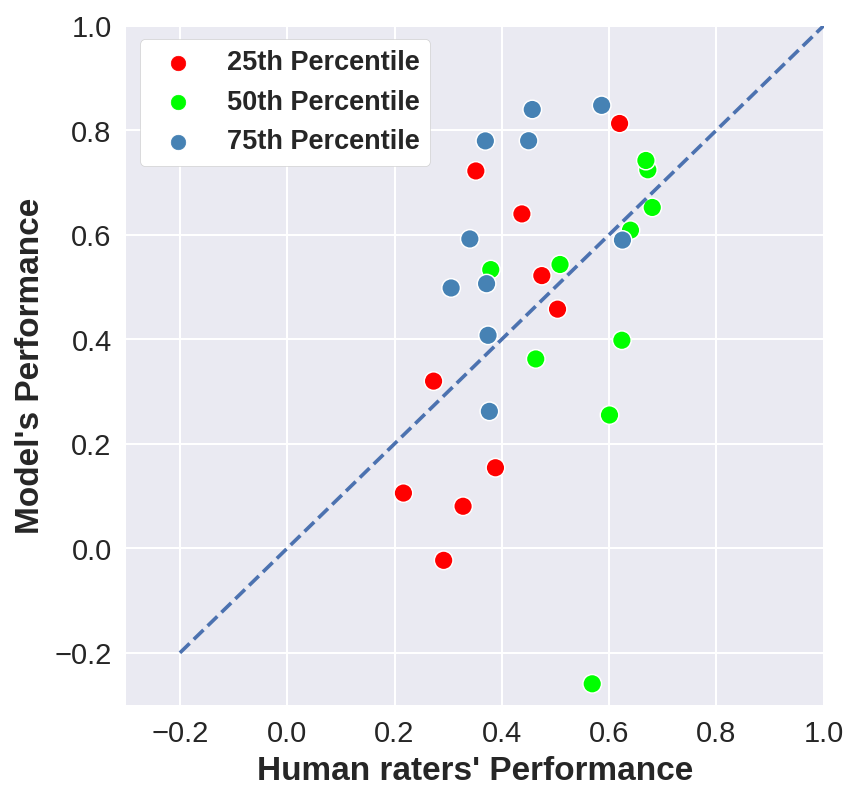

In [ ]:
n_steps = 10
cor_h, _, cor_c, _ = regCorr(target_list, n_steps, predictions_targets) #get performances

#plot dataframe
rows = []
targets=["25th Percentile", "50th Percentile", "75th Percentile"]
for i in range(3): #iterate over targets
  humans = nanmean(np.reshape(corr_h[i], (10,21)), 1) #reshape human performances to: test fold x rater, then get mean (average performance for each test fold)
  model = corr_c[i]
  target = [targets[i]]*10 #get name of the target
  rows.extend(list(zip(humans, model, target))) #save performance on each test fold as row for dataframe
df = pd.DataFrame(rows, columns=["humans", "model", "target"]) #save performances as pandas dataframe
color_mapping = {'25th Percentile':'red', '50th Percentile':'white', '75th Percentile':'blue'}
                                          
# plt.style.use("seaborn") #plot as scatter plot
fig, ax = plt.subplots(figsize=(6, 6), dpi = 150) #figure specs
sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, palette = ['red','lime',"steelblue"], alpha=1.0)
    
# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model\'s Performance', fontweight = "bold", fontsize=16)
ax.set_xlabel('Human raters\' Performance', fontweight = "bold", fontsize=16)
ax.legend(loc="upper left", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold','size':13})
ax.plot((-0.2, 1),(-0.2, 1), ls='--')
plt.xlim(-0.3,1)
plt.ylim(-0.3,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

from google.colab import files
# plt.savefig("fig3b.svg")
# files.download("fig3b.svg") 

Correlation of humans and model

In [ ]:
df.humans.corr(df.model)

0.3546540157212505

Total performances across all targets for each model

In [ ]:
# total performances across all targets
print("Model performance: " + str(round(nanmean(corr_c),3)))
print("Human performance: " + str(round(nanmean(corr_h),3)))

Model performance: 0.482
Human performance: 0.465


### Bar plot for construct/key prediction performance

#### Function for context plot creation

In [ ]:
#create functions:
def contextAccuracy(context="construct", i='Big5'):
  performance = pd.DataFrame(columns=["Dataset", "Target", "Model", "Accuracy"])
  #get the output data and path for respective context
  if context=="keys":
    m = 1
    par = 10  
    model, modelName = predModel(m,par) 
    e = "sentencebert"
    ending = "_encodings_constrBased"
    #load path and necessary variables:
    folder, data = chooseData(i)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
    embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
    savePath = path1 + folder + "new_results/by_embeddings/nonReversed/"
    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]
    # import required data and labels:
    embeddings_df = pd.read_csv(path1 + folder + data +  embeddings,index_col=0)
    constructs = pd.read_csv(path1 + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
    constrAssigned = constructs.loc[embeddings_df.index,:] #only take constructs/encodings of items with embeddings
    constrAssigned = constrAssigned[constrAssigned.construct != 'not assigned']
    constructs_list = constrAssigned.construct.drop_duplicates().values
    y = constrAssigned.encoding.replace([-1,1],[1,0])
    func = accuracy_keys
  elif context=="construct":
    ending = "_constructs"
    m = 1
    par = 1000 
    model, modelName = predModel(m,par) 
    e = "sentencebert"
    #load path and necessary variables:
    folder, data = chooseData(i)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
    embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
    savePath = path1 + folder + "new_results/by_embeddings/nonReversed/"
    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]
    # import required data and labels:
    embeddings_df = pd.read_csv(path1 + folder + data +  embeddings,index_col=0)
    constructs = pd.read_csv(path1 + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
    constrAssigned = constructs.loc[embeddings_df.index,:] #only take constructs/encodings of items with embeddings
    constrAssigned = constrAssigned[constrAssigned.construct != 'not assigned']
    constructs_list = constrAssigned.construct.drop_duplicates().values
    # print(constructs_list)
    #dicts to convert number to constructs and vice versa
    y_constr = constrAssigned.construct
    constrNr = {f: n for n, f in enumerate(constructs_list, 1)} #change construct name to integer for the prediction models
    y = pd.DataFrame(np.asarray((list(map(constrNr.get, y_constr)))), index= y_constr.index, columns=["constructs"]) #list of labels converted to numbers (1 to n)    
    func = accuracy_constr
  
  # get predicted responses of chosen model:
  total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + ending + ".csv", index_col=0)
  total_preds.index = total_preds.index.map(str)
  total_preds = total_preds.astype(float)

  total_preds2 = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + 'LIWC' + ending + ".csv", index_col=0)
  total_preds2.index = total_preds2.index.map(str)
  total_preds2 = total_preds2.astype(float)

  total_preds3 = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + 'WORD2VEC' + ending + ".csv", index_col=0)
  total_preds3.index = total_preds3.index.map(str)
  total_preds3 = total_preds3.astype(float)

  total_dumb = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + ending + '_dumb' + ".csv", index_col=0)
  total_dumb.index = total_dumb.index.map(str)
  total_dumb = total_dumb.astype(float)

  #get performance metrict
  results  = func(total_preds, y, constructs_list)
  results2 = func(total_preds2, y, constructs_list)
  results3 = func(total_preds3, y, constructs_list)
  results_dumb = func(total_dumb, y, constructs_list)

  #combine in single frame
  performance.loc[len(performance)] = [i, context, "Best Model",  results]
  performance.loc[len(performance)] = [i, context, "WORD2VEC",    results2]
  performance.loc[len(performance)] = [i, context, "LIWC",        results3]
  performance.loc[len(performance)] = [i, context, "Baseline", results_dumb]
  #combine correlations of all datasets in one frame
  return performance

#### Bar plots for all datasets

constructs and keys (directions)

running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

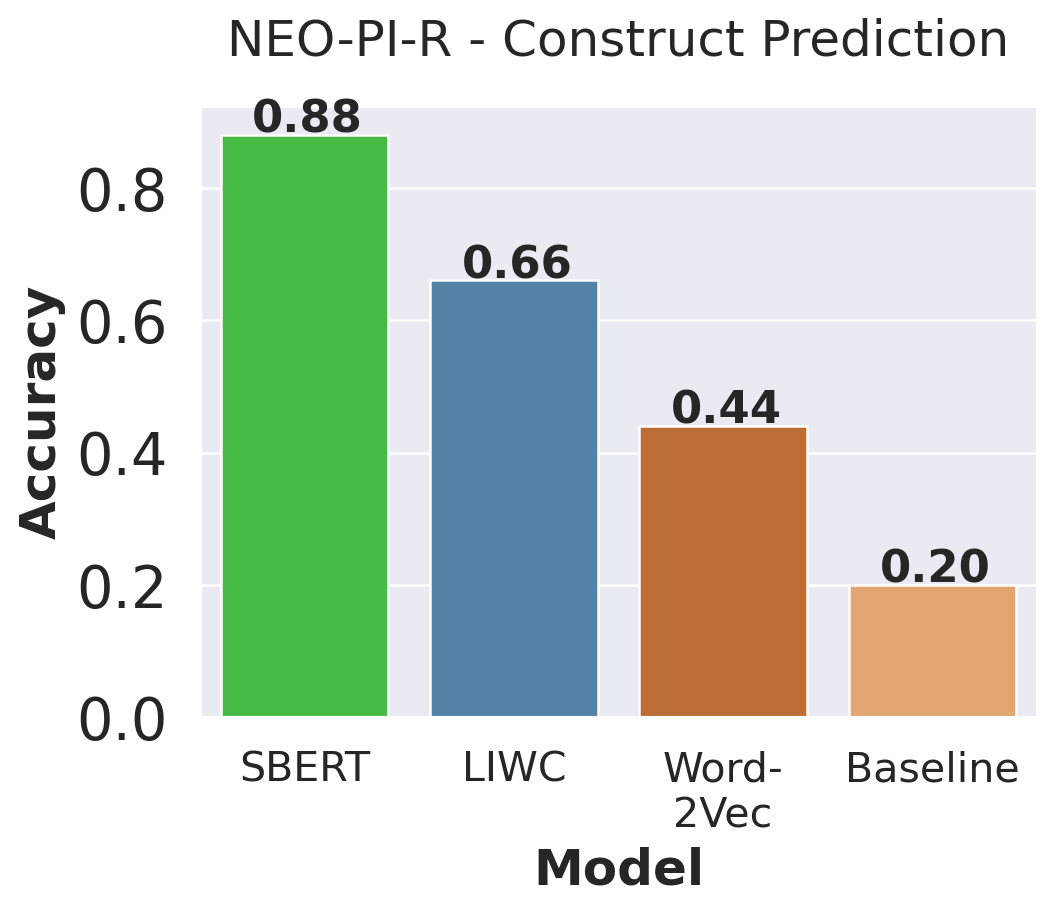

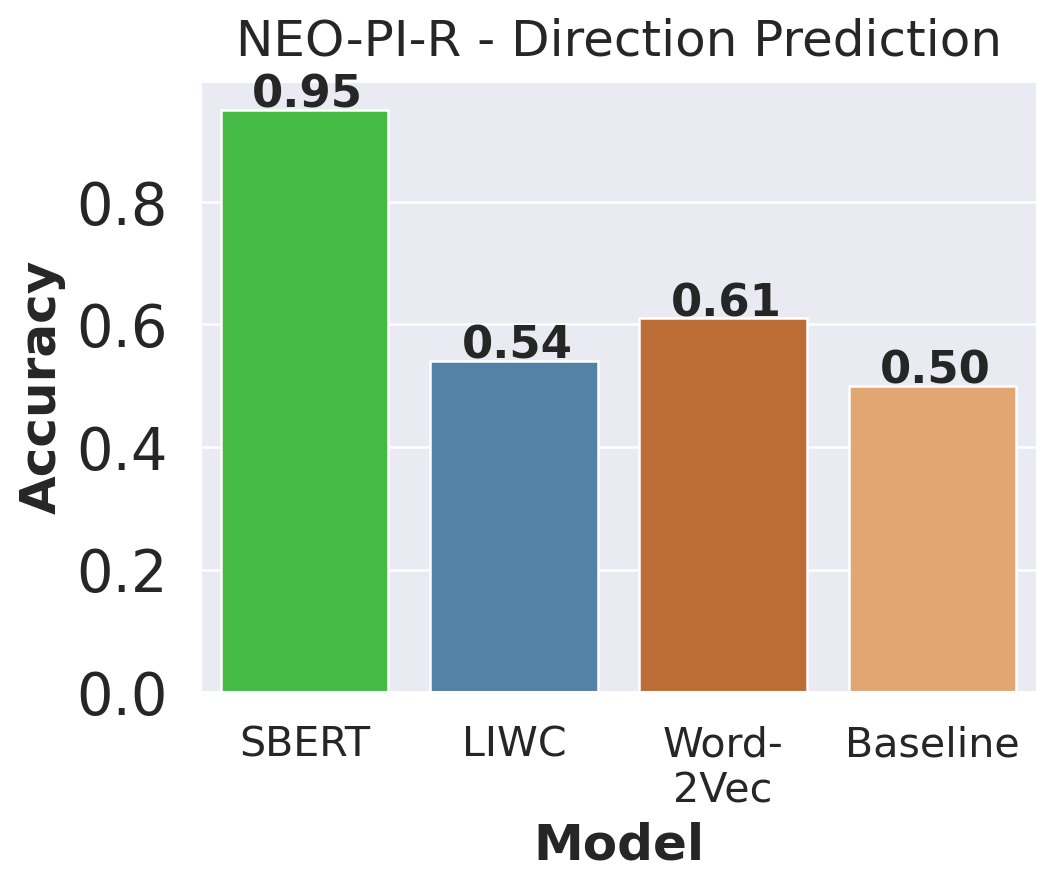

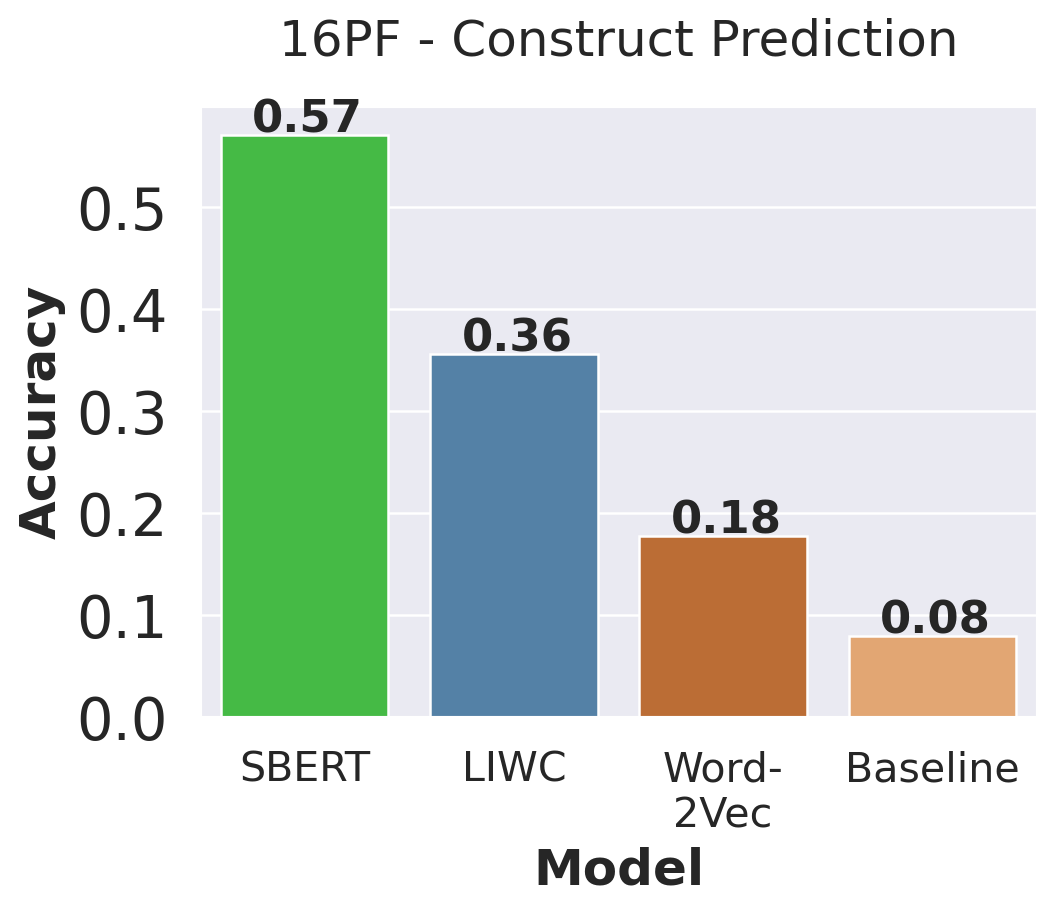

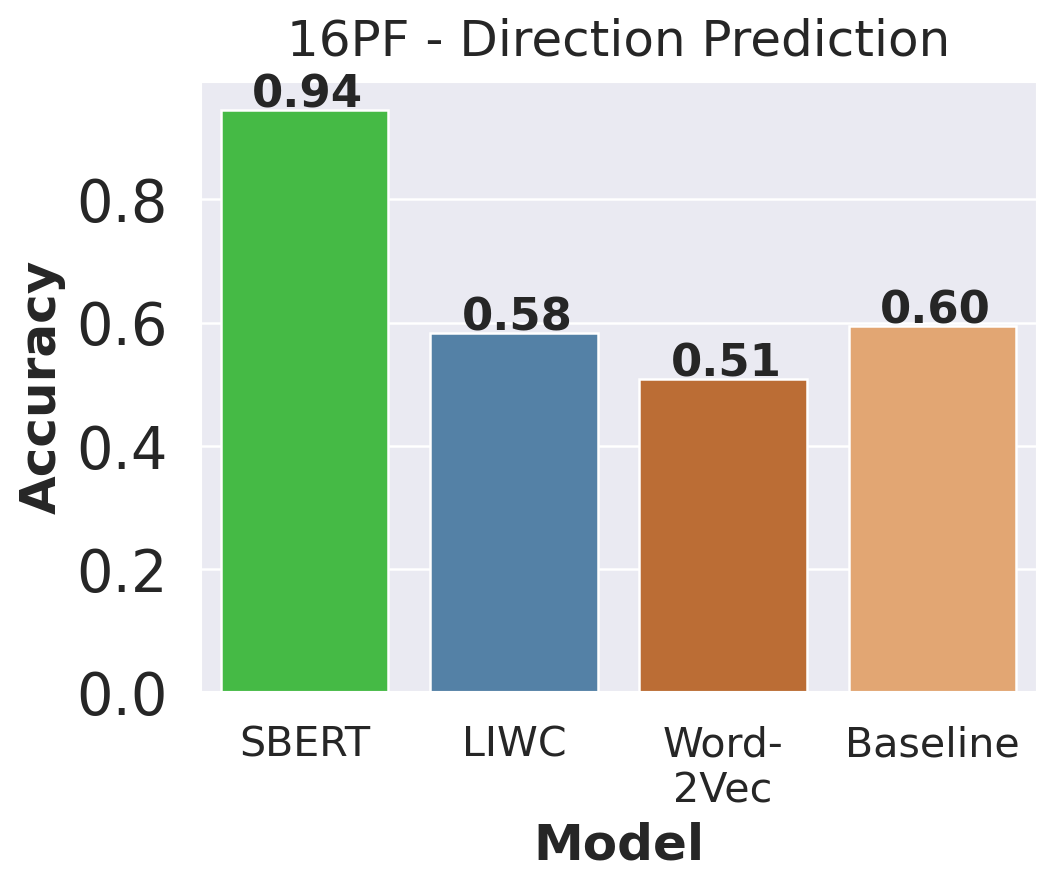

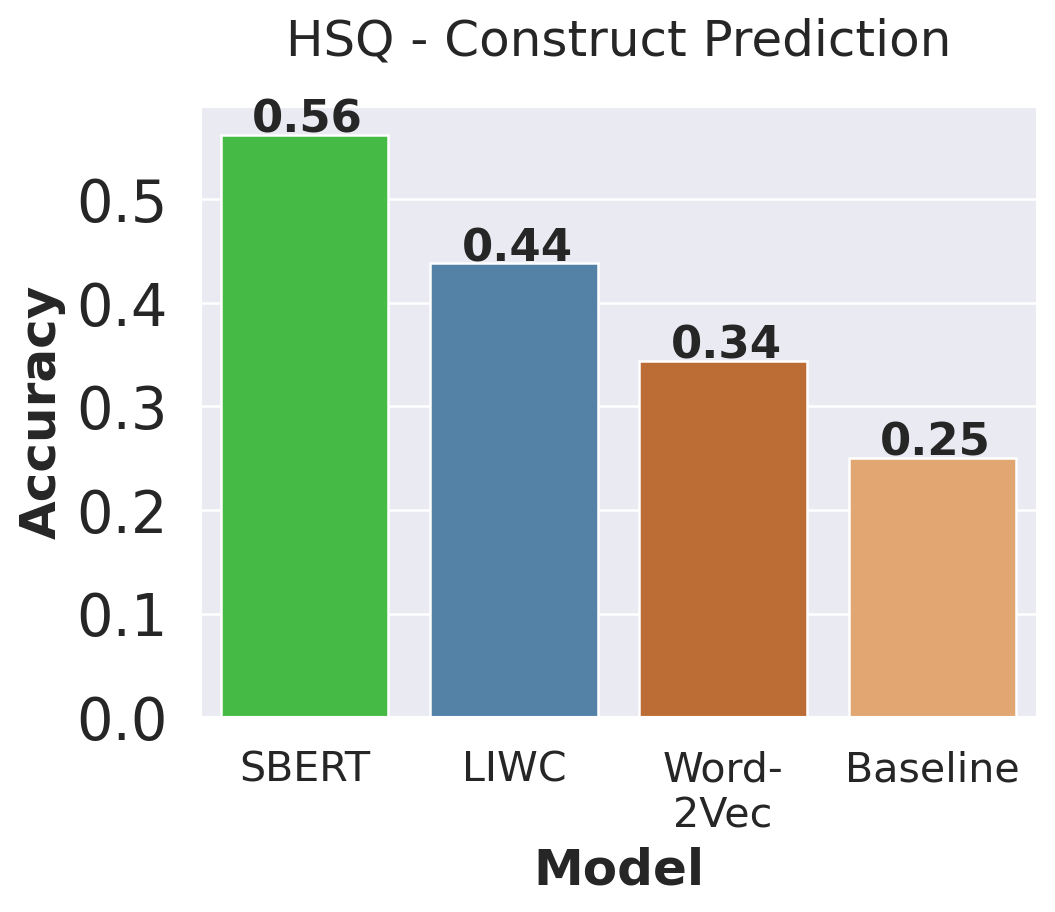

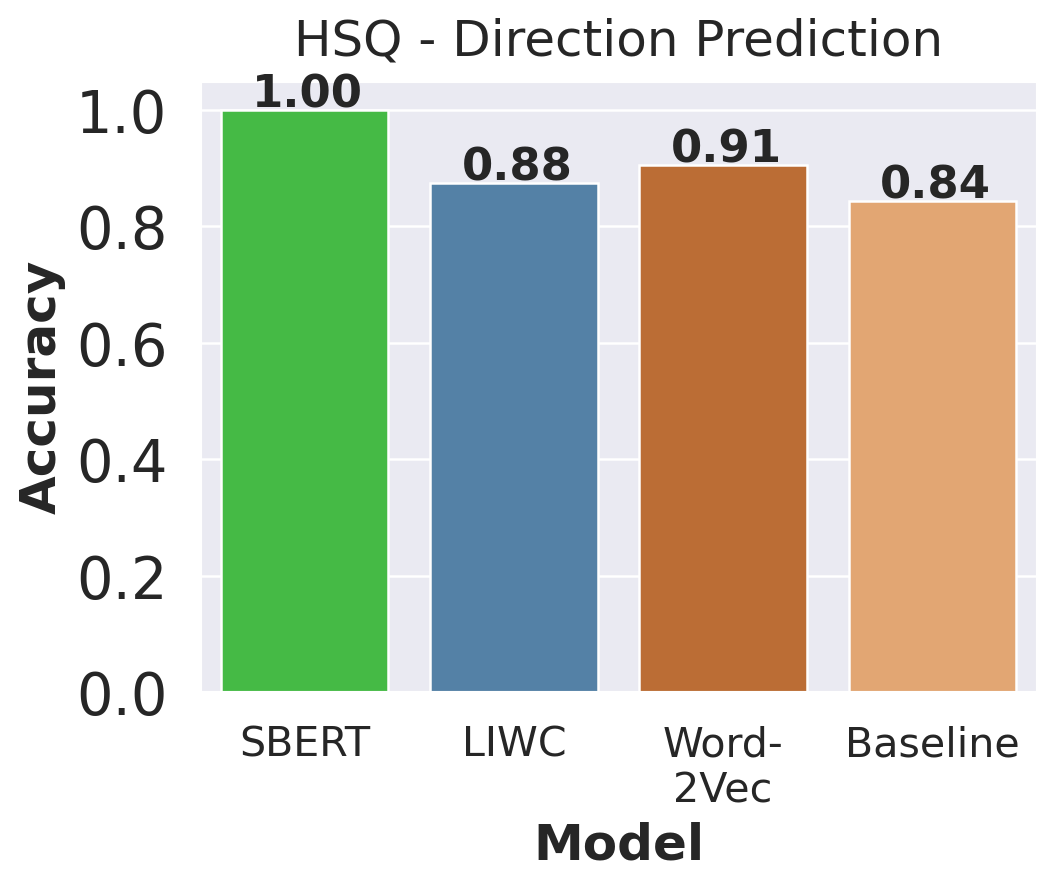

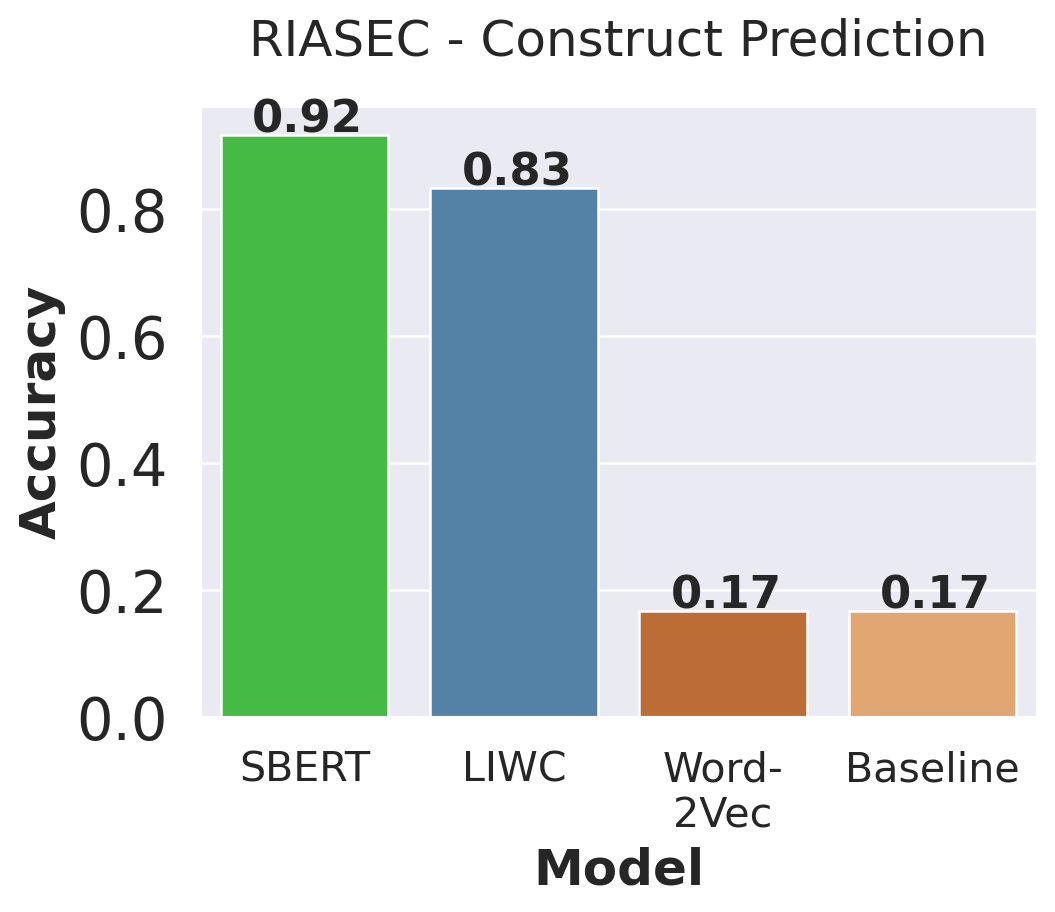

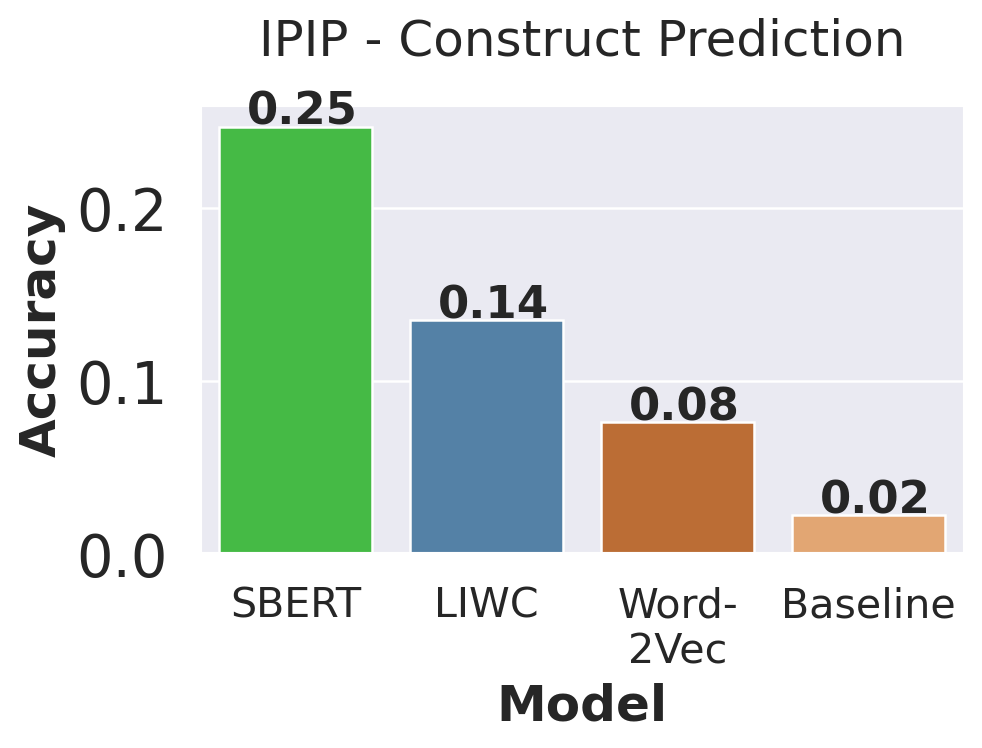

In [ ]:
# change to separate panels (subplots)

#new bar plots:
datasets_con = ['BIG5', '16PF', 'HSQ', 'RIASEC', 'IPIP2']
datasets_dir = ['BIG5', '16PF', 'HSQ']
names_con = ['NEO-PI-R', '16PF', 'HSQ', 'RIASEC', 'IPIP']
names_dir = ['NEO-PI-R', '16PF', 'HSQ']
performance_con = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])
performance_dir = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])

#iterate through datasets for construct data
for i,nr in zip(datasets_con, range(len(datasets_con))):
  results_con = contextAccuracy("construct", i)
  performance_con = performance_con.append(results_con)

#iterate through datasets for direction data
for i,nr in zip(datasets_dir, range(len(datasets_dir))):
  results_dir = contextAccuracy("keys", i)
  performance_dir = performance_dir.append(results_dir)

cols = performance_con.columns.drop(['Dataset', 'Target', 'Model'])
performance_con[cols] = performance_con[cols].astype(float)
performance_dir[cols] = performance_dir[cols].astype(float)

performance_con['Model'] = ["SBERT" if item=="Best Model" else item for item in performance_con['Model']]
performance_dir['Model'] = ["SBERT" if item=="Best Model" else item for item in performance_dir['Model']]
performance_con['Model'] = ["Word-\n2Vec" if item=="WORD2VEC" else item for item in performance_con['Model']]
performance_dir['Model'] = ["Word-\n2Vec" if item=="WORD2VEC" else item for item in performance_dir['Model']]

#Plot style and meta
plt.style.use('seaborn')
sns.set_context('paper')
sns.set(font_scale = 1.5)

l=0 #for labelling of the panels (if only one type of plot is plotted)
for i in range(5):
    # fig.add_subplot(5, 2, 2*i+1)
    fig  = plt.figure(figsize=(6, 4.5), dpi= 180)
    ax = sns.barplot(y='Accuracy', x='Model', order=["SBERT", "LIWC", "Word-\n2Vec", "Baseline"] , orient='v', data=performance_con[performance_con['Dataset']== datasets_con[i]], 
                     palette=["limegreen", "steelblue", "chocolate", "sandybrown"])
    for p in ax.patches:
      if p.get_height() < 0:
        height = -6
      else:
        height = 6
      ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 4, p.get_height()),
              xytext=(18, height), textcoords='offset points', ha="center", va="center", fontweight='bold',fontsize=18)

    plt.ylabel("Accuracy", fontweight='bold', fontsize=20)
    plt.xlabel("Model", fontweight='bold', fontsize=20)
    plt.title(names_con[i] + " - Construct Prediction", fontsize=20, pad=20)
    plt.yticks(size = 23)
    # ax.set_yticklabels(ax.get_yticks(), size = 20)
    
    fig_name = "fig5_" + chr(65+2*i) + ".pdf"
    from google.colab import files
    plt.savefig(fig_name, bbox_inches='tight')
    files.download(fig_name)

    #Add the direction plots for each data set:
    if i<3:
      # fig.add_subplot(5, 2, 2*i+2)
      fig  = plt.figure(figsize=(6, 4.5), dpi= 180)
      ax = sns.barplot(y='Accuracy', x='Model', order=["SBERT", "LIWC", "Word-\n2Vec", "Baseline"] , orient='v', data=performance_dir[performance_dir['Dataset']== datasets_dir[i]], 
                      palette=["limegreen","steelblue", "chocolate", "sandybrown"])
      for p in ax.patches:
        if p.get_height() < 0:
          height = -6
        else:
          height = 6
        ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 4, p.get_height()),
                xytext=(18, height), textcoords='offset points', ha="center", va="center", fontweight='bold',fontsize=18)

      plt.ylabel("Accuracy", fontweight='bold', fontsize=20)
      plt.xlabel("Model", fontweight='bold', fontsize=20)
      plt.title(names_dir[i] + " - Direction Prediction", fontsize=20, pad=10)
      plt.yticks(size = 23)
      l=0
      fig_name = "fig5_" + chr(65+2*i+1) + ".pdf"
      from google.colab import files
      plt.savefig(fig_name, bbox_inches='tight')
      files.download(fig_name)
    else:
      l=1
plt.tight_layout()

# from google.colab import files
# plt.savefig("fig4a.svg")
# files.download("fig4a.svg")

keys

### Visualising Question Embeddings: Wordclouds

Define Dataset and embeddings type:

In [ ]:
d = "ipip"          #IPIP: all items, IPIP2: only assigned
e = "sentencebert"

# #choose data set, embeddings, encoding
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
# embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
# responses, savePath, items, _ = getResponses(path1, folder, data, 2) #1: Reversed, #2: nonReversed
# X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#read in embeddings, order them like the response data and save in vector
embeddings_df = pd.read_csv(path1 + folder + 'ipip_full_questions_embeddings_SENTENCEBERT.csv',index_col=0)
constrAssigned = pd.read_csv(path1 + folder + "ipip_questions_text.csv", encoding = 'utf-8',index_col=0)

X = embeddings_df.copy()

# ################################ Preprocess input data::
#Standardize for regression (wihtout PCA)
X_stand = pd.DataFrame(StandardScaler().fit_transform(X)) #standardize embeddings
#With PCA, for regression, 90% variance explained
X_pca = pd.DataFrame(PCA(0.9, random_state=0).fit_transform(X_stand),index=embeddings_df.index) 

Clustering based on question embeddings

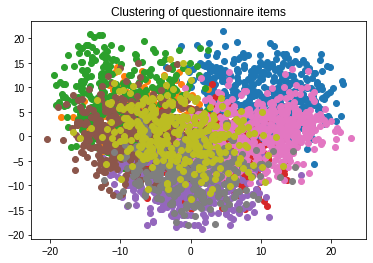

In [ ]:
#Number of clusters
k = 9
#include/exclude non assigned items
nAssigned = 1

if nAssigned == 0:
  plt_emb = X.iloc[np.where(constrAssigned.construct != 'not assigned')]
else:
  plt_emb = X_pca

#K-Means clustering
model = KMeans(n_clusters = k, random_state=2)
model.fit(plt_emb)
yhat = model.predict(plt_emb)
#2D reduction for plotting
all_emb = PCA(2, random_state=0).fit_transform(plt_emb) #2D dimension reduction

clusters = np.unique(yhat) # retrieve unique clusters
# create scatter plot for samples from each cluster
for cluster in clusters:
	row_ix = np.where(yhat == cluster)[0]                 # get row indexes for samples with this cluster
	plt.scatter(all_emb[row_ix, 0], all_emb[row_ix, 1]) # create scatter plot
plt.title("Clustering of questionnaire items")
plt.style.use('seaborn')
plt.show()

#createa dataframe that contains all items grouped by cluster
itemlist = constrAssigned.loc[plt_emb.index,'item'].drop_duplicates() #get the item texts
clusterOverview = pd.DataFrame(np.full((1,k),0))
clusters = []
for i in range(k):
  clusters.append(np.where(yhat==i)[0]) #get item indices for each cluster
find = list(range(len(itemlist)))
replace = itemlist
clusterOverview = pd.DataFrame(clusters).T.replace(find, replace) #replace the indices with item texts

#### Define Functions for preprocessing

In [ ]:
#load libraries and define preprocessing function (most preprocessing has already been done previously for other tasks)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter

import nltk
import re
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

#Define tokenisation functions
def preprocess(items):
  #remove symbols
  symbols = "!#$%&()*+-./:;<=>?@[\]^_`{|}~"
  for i in symbols:
      items = [word.replace(i, ' ') for word in items]
  docs = [[lemmatizer.lemmatize(word) for word in sublist.split()] for sublist in items] #lemmatise
  items = [" ".join(sublist) for sublist in docs] #unflatten list
  return items, docs

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#### Find most frequent terms in the IPIP

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


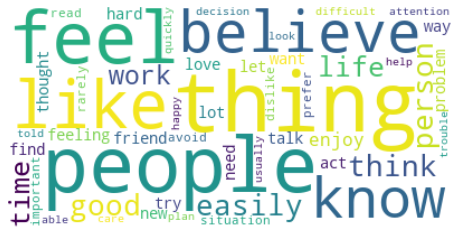

In [ ]:
# find good stop words:
#get the texts 
texts = pd.DataFrame(clusterOverview.values.flatten()).dropna().values.flatten()
docs = texts.tolist() #all items as individual strings in list

#preprocess: remove symbols, stopwords, lemmatise, stemming
total_items, total_docs = preprocess(docs)
#eliminate basic stop words
# stopwords=stop_words.ENGLISH_STOP_WORDS
sp_words, _ = preprocess(STOP_WORDS)

# use tf-idf, calculate frequencies and find the most frequent ones in the document -> add to stop words list
vec=TfidfVectorizer(max_df=0.85,stop_words=sp_words, preprocessor=lambda x: re.sub(r'(\d[\d\.])+', '', x.lower()))
tfidf_vector=vec.fit_transform(total_items)
feature_names = vec.get_feature_names()
dense = tfidf_vector.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
frequency = df.T.sum(1)
Cloud = WordCloud(background_color="white", max_words=50, random_state=0, stopwords=sp_words).generate_from_frequencies(frequency)#.generate(" ".join(total_items))#
plt.imshow(Cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# remove words frequent across all documents -> improve wordclouds by removing too generic terms
a = list(sp_words)
a.extend(frequency.sort_values()[::-1][0:10].index.tolist())

Word Clouds by cluster

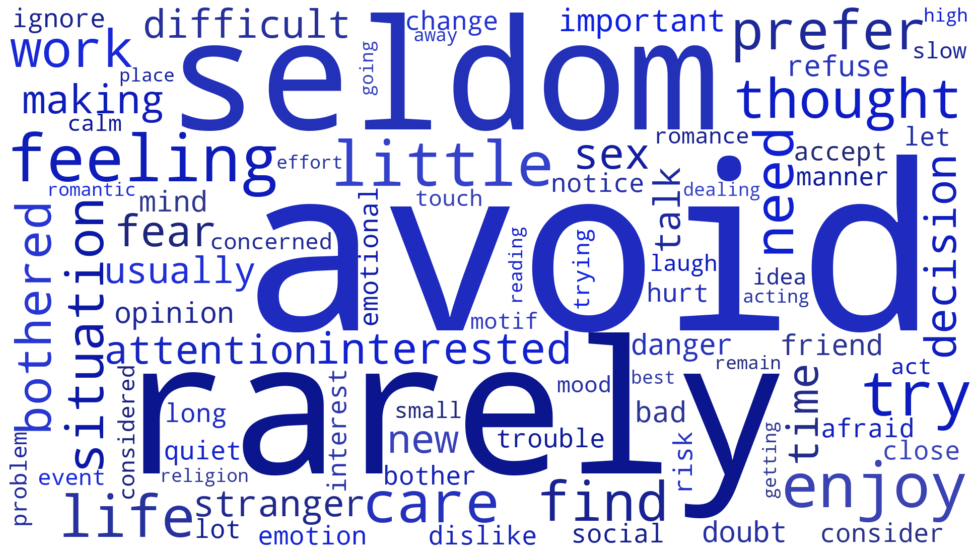

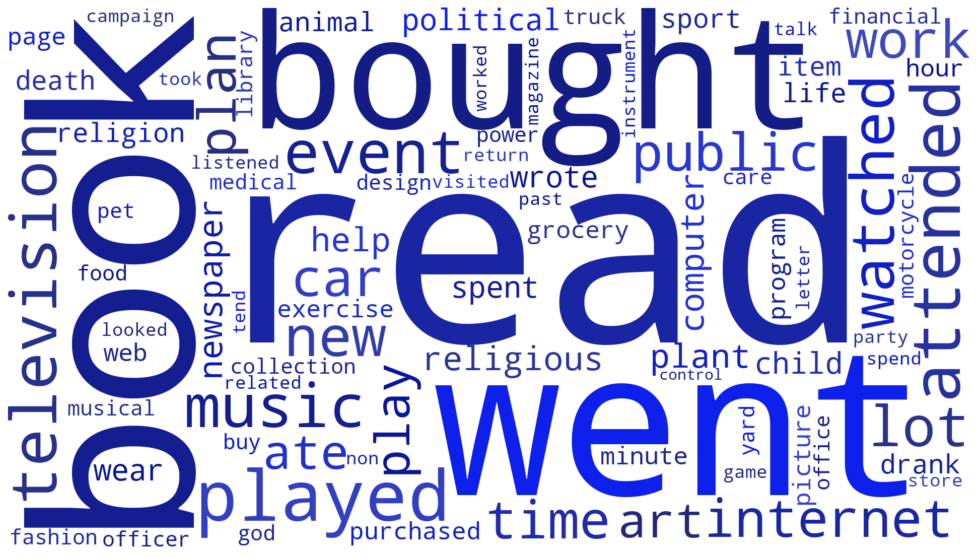

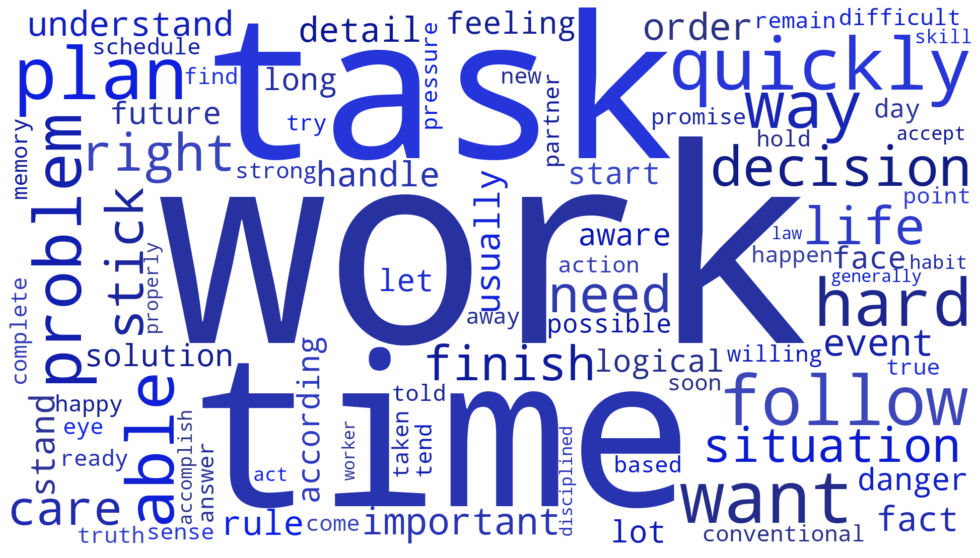

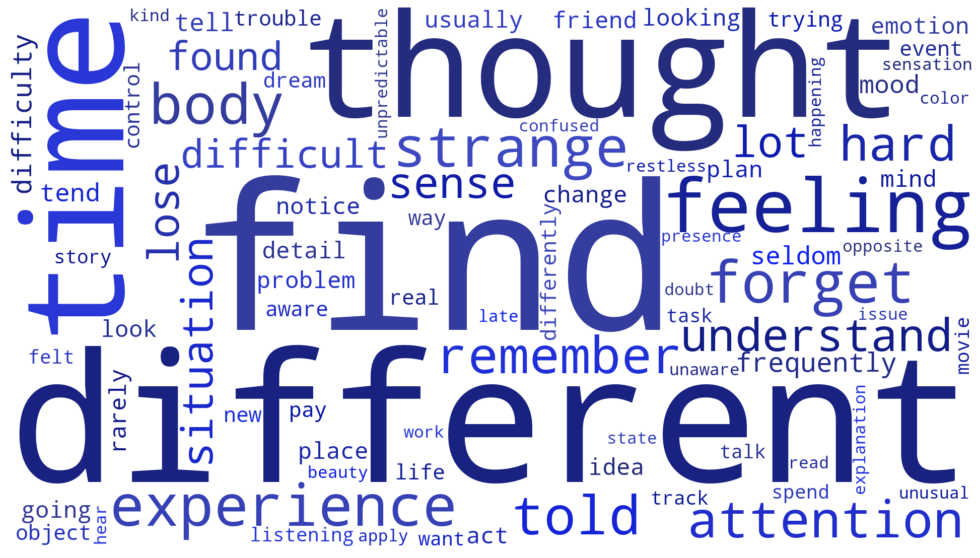

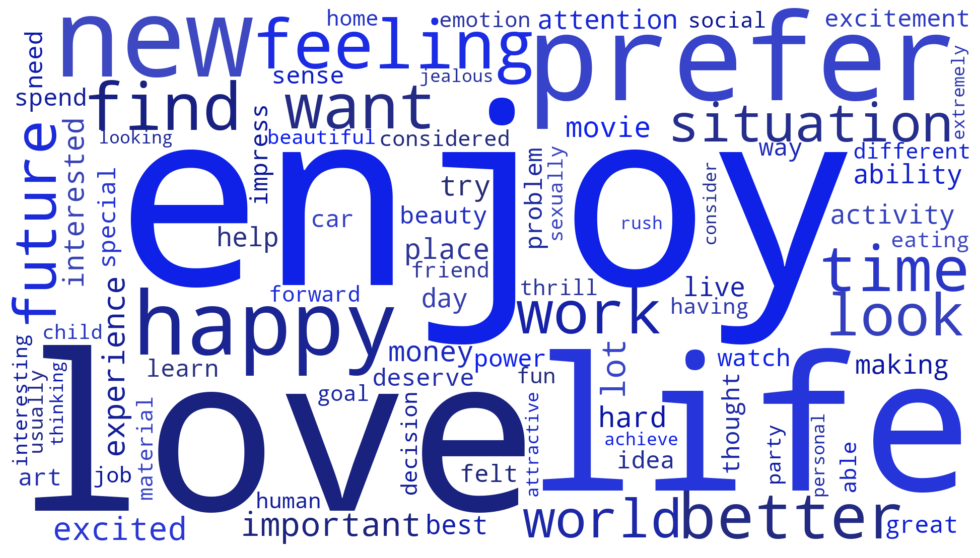

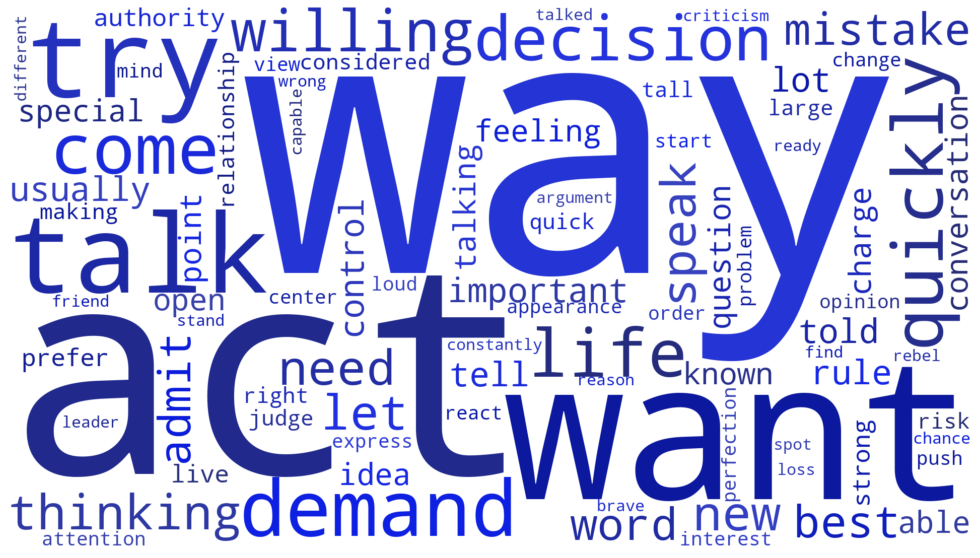

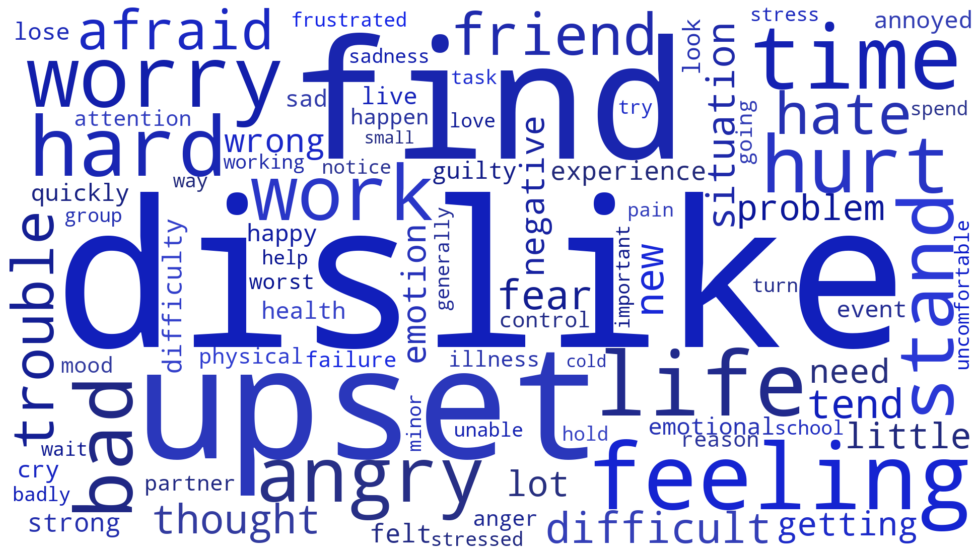

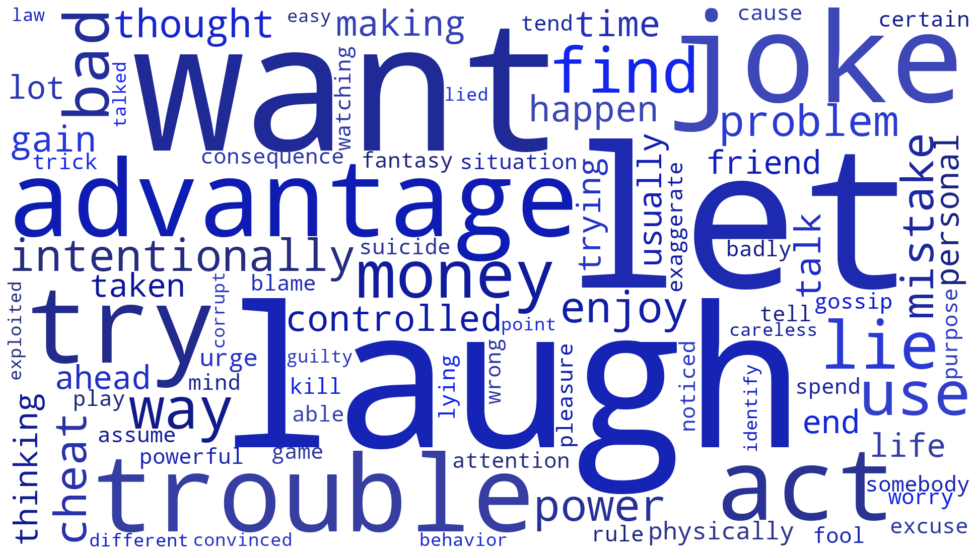

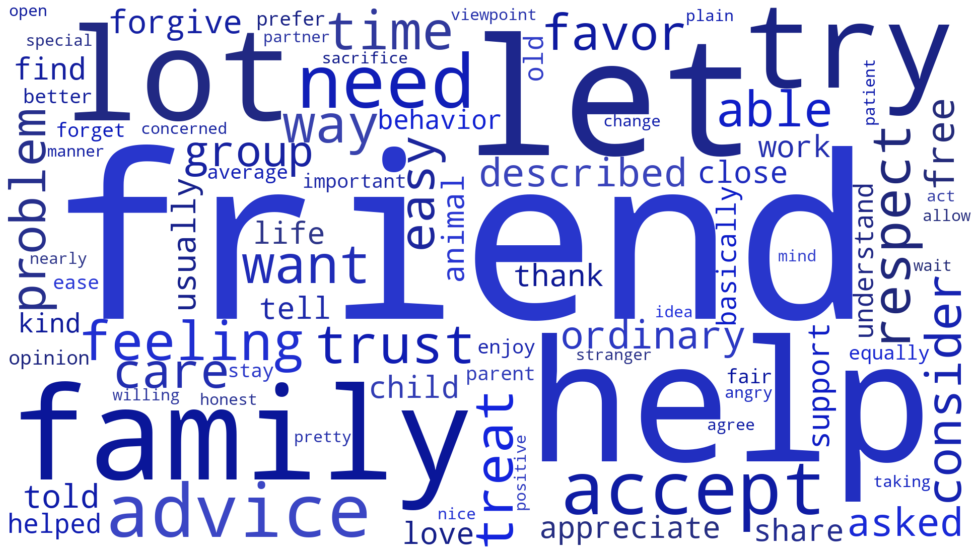

In [ ]:
#create word clouds for each cluster
import random
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    c1 = round(random.randint(50, 90),3)
    c2 = round(random.randint(30, 50),3)
    return "hsl(235, " + str(c1) + "%, " + str(c2) + "%)"

for nc in range(clusterOverview.shape[1]):
  # preprocess
  cluster_texts = clusterOverview[nc].dropna().values # all cluster item texts
  cluster_items, cluster_docs = preprocess(cluster_texts)
  Cloud = WordCloud(background_color="white", stopwords=a, max_words=85, random_state=0, collocations=False, width=1920, height=1080).generate(" ".join(cluster_items))#.generate_from_frequencies(cluster_frequency)
  plt.figure(figsize=(20,10))
  plt.imshow(Cloud, interpolation='bilinear')
  plt.imshow(Cloud.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
  plt.axis("off")
  plt.show()

Check which constructs are in the clusters

In [ ]:
#get the constructs from the IPIP that are in our new clusters
clusterConstructs = pd.DataFrame()
for i in range(clusterOverview.shape[1]):
  items = clusterOverview.iloc[:,i]
  #get construct
  constructs_idx = np.where(constrAssigned.item.isin(items))[0]
  constructs = constrAssigned.construct[constructs_idx].values
  #summarise which constructs occur how often
  summary = Counter(constructs)
  #get 5 (excluding "not assigned") most frequent one with number:
  clusterConstructs[i] = summary.most_common(10)
clusterConstructs

0  ...                                             8
0                             (not assigned, 205)  ...                           (not assigned, 159)
1                             (sentimentality, 6)  ...                        (forgiveness/mercy, 7)
2  (aesthetic appreciation/artistic interests, 6)  ...                           (responsibility, 6)
3                     (creativity/originality, 5)  ...                         (modesty/humility, 6)
4                                   (prudence, 5)  ...  (conformity/dependence/need for approval, 6)
5                           (modesty/humility, 5)  ...                      (kindness/generosity, 5)
6   (introspection/private self-consciousness, 5)  ...                                 (altruism, 5)
7                               (friendliness, 4)  ...                                    (trust, 5)
8                                (callousness, 4)  ...                     (teamwork/citizenship, 4)
9    (conformity/dependence/need for approval, 4)  ...                                  (empathy, 4)

[10 rows x 9 columns]

Find items of interest in a cluster

In [ ]:
cl = 1 #cluster
search = "life" #search word
mask = clusterOverview.iloc[:,cl].str.contains(search).fillna(False)
df = clusterOverview.loc[(mask),clusterOverview.columns[cl]].copy(deep=True)
df

### Construct/Item similarities

Get embeddings of items in each construct. <br>
Then, test for significance (t-test against zero) whether items within a construct are more similar (cosine similarity) compared with items outside of a construct, controlled for the respective constructs.

running KnnReg: 




BIG5
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     103.5
Date:                Mon, 27 Sep 2021   Prob (F-statistic):          3.28e-104
Time:                        04:21:35   Log-Likelihood:                 2757.0
No. Observations:                4950   AIC:                            -5502.
Df Residuals:                    4944   BIC:                            -5463.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2898     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>





HSQ
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     8.744
Date:                Mon, 27 Sep 2021   Prob (F-statistic):           7.98e-07
Time:                        04:21:35   Log-Likelihood:                 244.77
No. Observations:                 496   AIC:                            -479.5
Df Residuals:                     491   BIC:                            -458.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5785      0.022   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Index(['Realistic', 'Investigative', 'Artistic', 'Social', 'Enterprising',
       'Conventional'],
      dtype='object')




RIASEC
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     66.10
Date:                Mon, 27 Sep 2021   Prob (F-statistic):           1.99e-70
Time:                        04:22:01   Log-Likelihood:                 1044.5
No. Observations:                1128   AIC:                            -2075.
Df Residuals:                    1121   BIC:                            -2040.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.9

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>





16PF
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     58.10
Date:                Mon, 27 Sep 2021   Prob (F-statistic):          5.09e-181
Time:                        04:22:12   Log-Likelihood:                 7540.5
No. Observations:               13203   AIC:                        -1.505e+04
Df Residuals:                   13186   BIC:                        -1.492e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3316      0.007     47.313

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

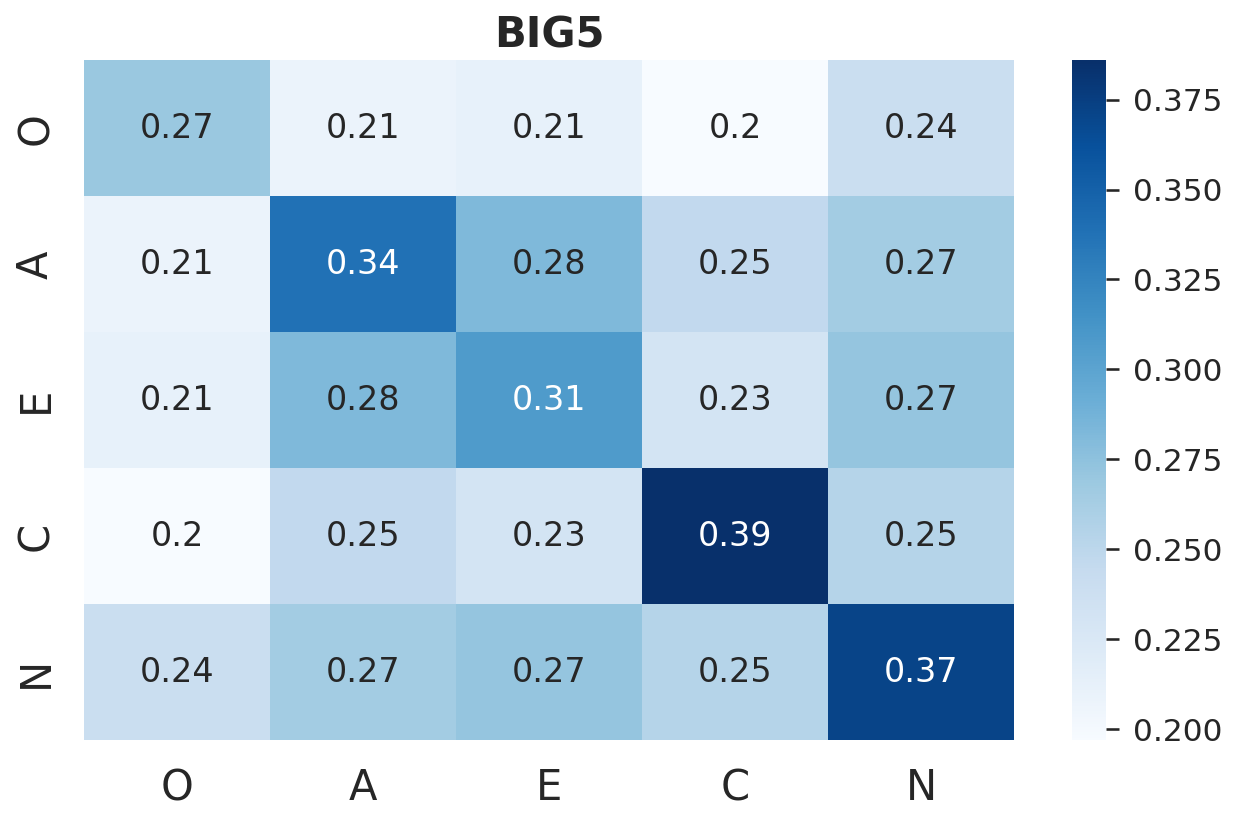

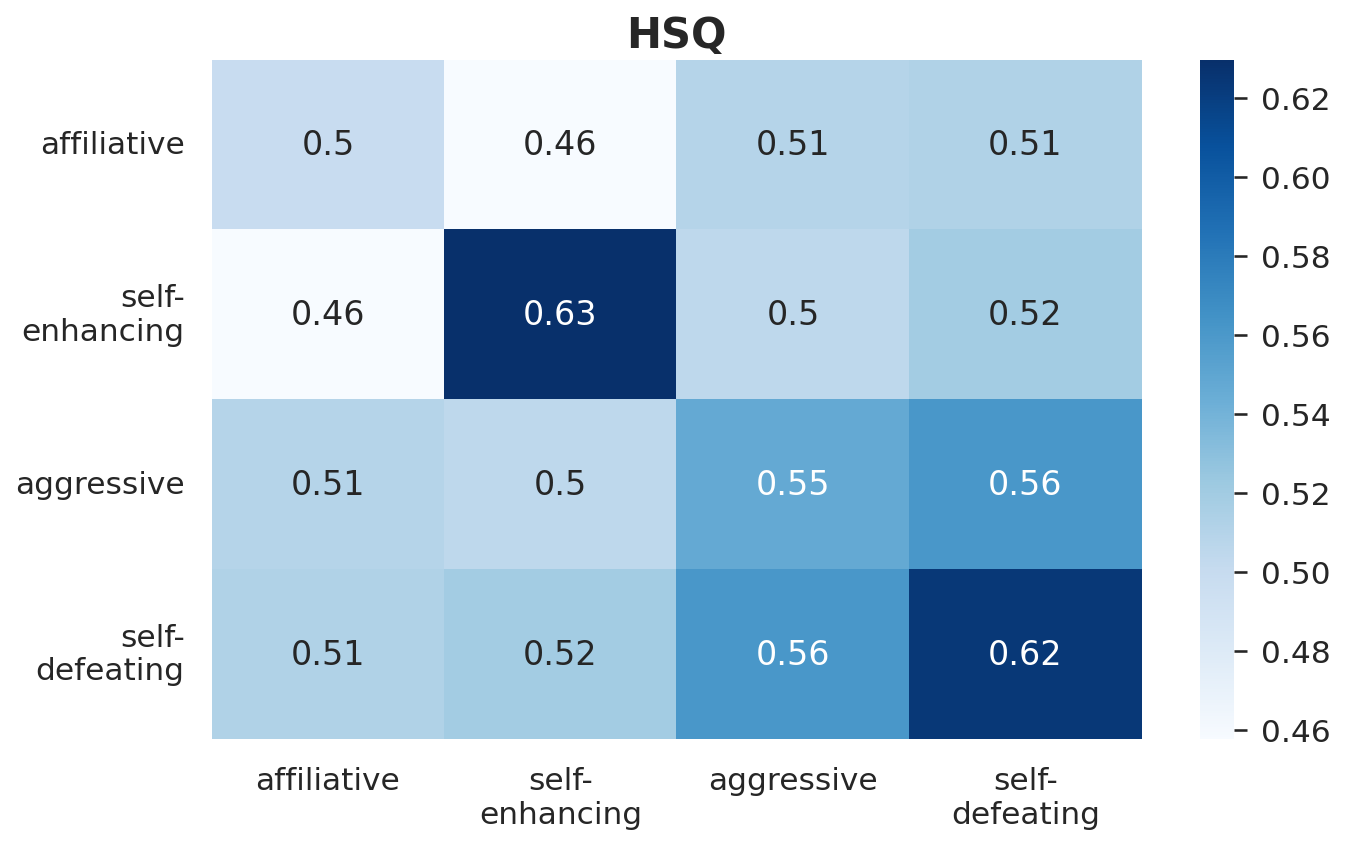

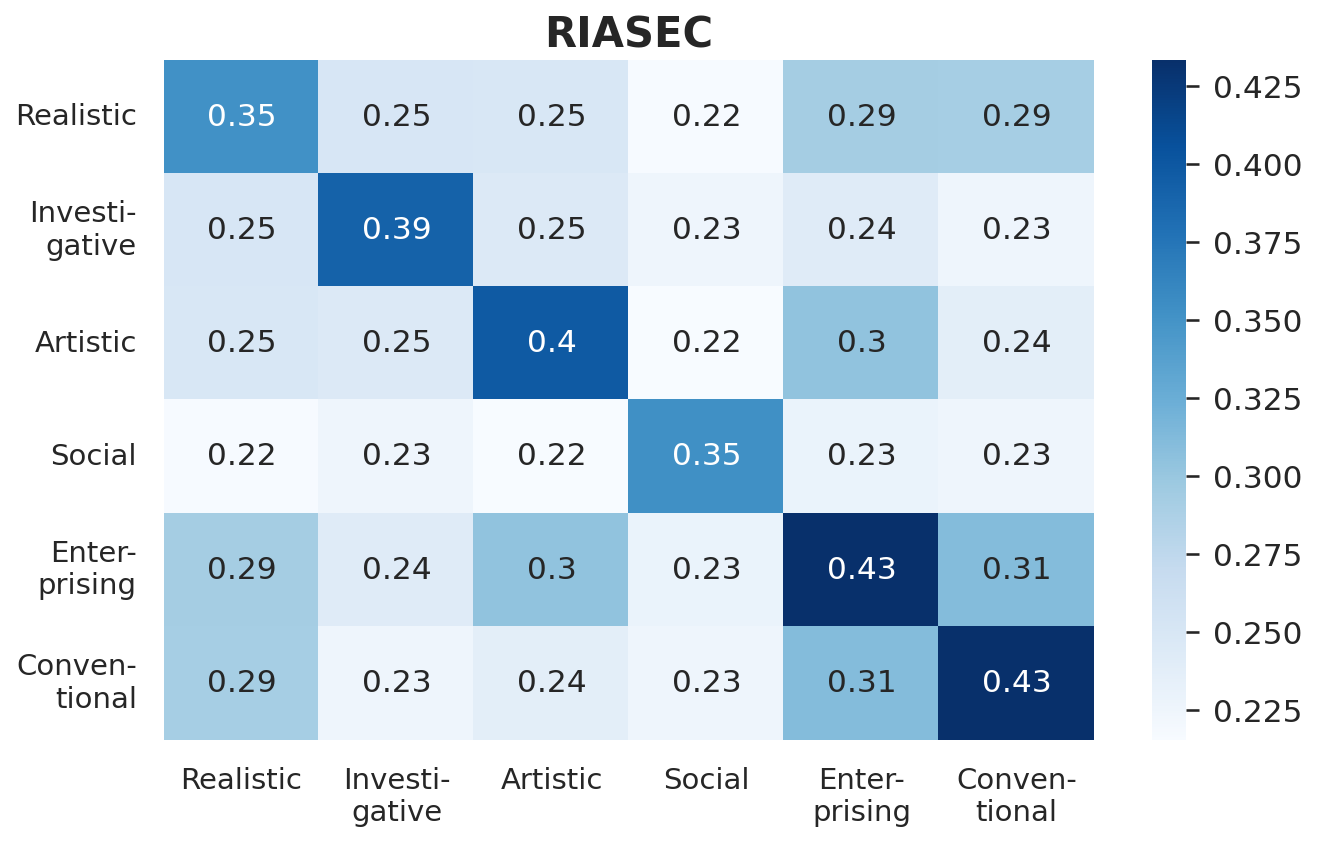

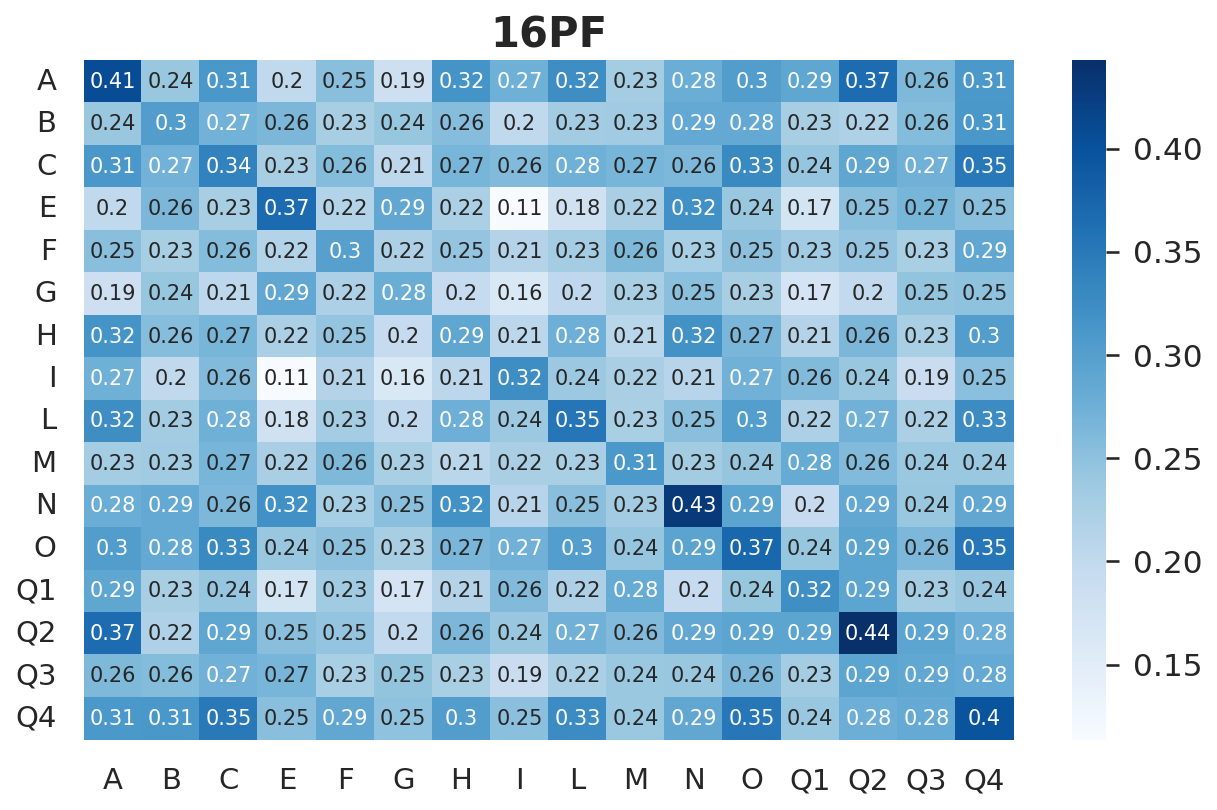

In [ ]:
## Finish commenting
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.formula.api as sm
import itertools

# BIG5

#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
datasets = ["BIG5", 'HSQ', 'RIASEC', "16PF"]
# d = "BIG5"      #BIG5, 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 


#load path and necessary variables:
for d in datasets:
  folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
  embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
  responses, savePath, items, _ = getResponses(path1, folder, data, R) #1: Reversed, #2: nonReversed
  responses = responses.astype(float) #get observed responses as floats
  X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

  # import required data and labels:
  data_q, constructs_list, list_par, constrAssigned = getData(1)

  #calculate construct similarities
  item_values = pd.DataFrame(columns=constructs_list, index=constructs_list)
  item_groups = pd.DataFrame(columns=constructs_list, index=constructs_list)
  sim_df = pd.DataFrame(columns=constructs_list, index=constructs_list)
  for constr_A in constructs_list:
    idx_A = np.where(constrAssigned.construct == constr_A)[0]
    for constr_B in constructs_list:
      idx_B = np.where(constrAssigned.construct == constr_B)[0]
      if constr_B == constr_A:
        sim = cosine_similarity(X.iloc[idx_A], X.iloc[idx_B])
        similarity_cleaned = []
        for i in range(sim.shape[0]):
          temp = sim[i][i+1:]
          similarity_cleaned.extend(temp)
        sim = similarity_cleaned
        similarity = np.array(sim).mean()
        item_values.loc[constr_A, constr_B] = sim        #save item level similarity over the whole constructs
        item_groups.loc[constr_A, constr_B] = [constr_A + "-" + constr_B]*len(sim)
      else:
        sim = cosine_similarity(X.iloc[idx_A], X.iloc[idx_B])
        similarity = sim.mean()
        item_values.loc[constr_A, constr_B] = sim.flatten().tolist()        #save item level similarity over the whole constructs
        item_groups.loc[constr_A, constr_B] = [constr_A + "-" + constr_B]*len(sim.flatten().tolist())
      sim_df.loc[constr_A, constr_B] = similarity      #save average similarity
  sim_df = sim_df.astype(float)

  # change construct name to make it shorter to fit into figure
  if d=="BIG5":
    construct_list = sim_df.columns
  elif d=="HSQ":
    construct_list = sim_df.columns
    construct_list = ["self-\nenhancing" if item=="selfenhancing" else item for item in construct_list]
    construct_list = ["self-\ndefeating" if item=="selfdefeating" else item for item in construct_list]
    sim_df.columns = construct_list
    sim_df.index = construct_list
  elif d=="RIASEC":
    construct_list = sim_df.columns
    print(construct_list)
    construct_list = ["Investi-\ngative" if item=="Investigative" else item for item in construct_list]
    construct_list = ["Enter-\nprising" if item=="Enterprising" else item for item in construct_list]
    construct_list = ["Conven-\ntional" if item=="Conventional" else item for item in construct_list]
    sim_df.columns = construct_list
    sim_df.index = construct_list
  if d=="16PF":  
    construct_list = sim_df.columns 


  #show plots
  fig, ax = plt.subplots(figsize=(10, 6), dpi = 150) #figure specs
  if d=="BIG5":
    # sns.set(font_scale=1.5)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":16})
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
  elif d=="HSQ":
    # sns.set(font_scale=1.5)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":16})
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
  elif d=="RIASEC":
    # sns.set(font_scale=1.3)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":15})
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
  elif d=="16PF":
    # sns.set(font_scale=0.7)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":10})
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)

  ########################### test for significance:

  print("\n\n\n")
  print(d)

  outclass_values = []
  outclass_groups = []
  inclass_values = []
  inclass_groups = []

  for n in range(len(constructs_list)):
    
    # inclass_df = pd.DataFrame(columns=["in_class", "similarity"])
    # inclass_df.similarity = item_values.iloc[n,n]
    # inclass_df.in_class = [1]*len(item_values.iloc[n,n])


    # for i in range(item_values.shape[0]):
    #   if i!=n:
    #     outclass_list.extend(item_values.iloc[i,n])
    #   else:
    #     inclass_list.extend(item_values.iloc[i,n])
    # len(outclass_values)
    if n!= len(constructs_list)-1:
      outclass_values.extend(list(itertools.chain.from_iterable(item_values.iloc[n+1:,n]))) #items below diagonal are between constructs (matrix is symmetric so only take values below diagonal)
      outclass_groups.extend(list(itertools.chain.from_iterable(item_groups.iloc[n+1:,n]))) #get the names of the item pairs' constructs
    inclass_values.extend(item_values.iloc[n,n]) #values on the diagonal are within construct
    inclass_groups.extend(item_groups.iloc[n,n]) 

  outclass_df = pd.DataFrame(columns=["in_class", "similarity", "construct_1", "construct_2"])
  outclass_df.similarity = outclass_values
  outclass_df.construct_1 = [x.split("-")[0] for x in outclass_groups]
  outclass_df.construct_2 = [x.split("-")[1] for x in outclass_groups]
  outclass_df.in_class = [0]*len(outclass_values)
  
  inclass_df = pd.DataFrame(columns=["in_class", "similarity", "construct_1", "construct_2"])
  inclass_df.similarity = inclass_values
  inclass_df.construct_1 = [x.split("-")[0] for x in inclass_groups]
  inclass_df.construct_2 = [x.split("-")[1] for x in inclass_groups]
  inclass_df.in_class = [1]*len(inclass_values)
  merged_df = pd.concat([inclass_df,outclass_df])
  
  c1 = pd.get_dummies(merged_df["construct_1"])
  c2 = pd.get_dummies(merged_df["construct_2"])
  combined = c1 | c2

  final_df = pd.concat([merged_df.iloc[:,:-2], combined], axis=1)

  model = sm.ols(formula = "similarity ~ in_class + " + "+".join(constructs_list[:-1]), data=final_df)
  res = model.fit()
  # print(constructs_list[n])
  print(res.summary())
  # break

  from google.colab import files
  fig_name = "similarities_" + d + ".pdf"
  plt.title(d, fontsize=20, fontweight="bold")
  plt.savefig(fig_name, bbox_inches='tight')
  files.download(fig_name)

  # plt.show()

# Reverse-coding responses (auxiliary code)

Import responses

In [ ]:
#data:
d = "hsq"         # BIG5, IPIP2, RIASEC, HSQ,

#choose data set, embeddings, encoding
folder, data = chooseData(d) 
embeddings, save = chooseEmb('use') 
responses, _, _ = getResponses(path1, folder, data, 1)
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)
_, _, _, constrAssigned = getData(1)

#rename:
responses_df = responses
questions_df = constrAssigned

Check min/max values, removing non-defined values (out of scale)

In [ ]:
# # check max values
print(responses_df.max().max())
print(responses_df.min().min())

# remove all rows with 0
#responses_df = responses_df.iloc[:,:-2]
responses_df = responses_df[(responses_df != 0).all(1)]
responses_df = responses_df[(responses_df != -1).all(1)]

responses_df.shape #check dataframe dimensions

Reversing responses

In [ ]:
# Changing from reverse-coded to non-reverse-coded and vice versa

max_response_value = responses_df.values.max() #find max value

#find questions that have to be reversed coded
question_key = questions_df.encoding == -1           

#flip responses
responses_df.loc[:,question_key] = max_response_value - responses_df.loc[:,question_key] + 1

Save reversed responses

In [ ]:
#responses_df.to_csv(dataset_path+folder+data+"responses.csv", header=True)

# Human rater evaluation

Load best model

In [ ]:
#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "big5"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 

#load path and necessary variables:
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
responses, savePath, items, _ = getResponses(path1, folder, data, R) #1: Reversed, #2: nonReversed
responses = responses.astype(float) #get observed responses as floats
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels:
data_q, constructs_list, list_par, constrAssigned = getData(1)

# get predicted responses of chosen model:
total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

#get performance:
corr, means = corrUserBased(total_preds, responses)

running KnnReg: 


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Find Target Participants

In [ ]:
S = corr.Correlation.sort_values()
for q in [0.25, 0.5, 0.75]:
  percentage_rank = S.rank(method="max", pct=True)
  idx = S.index[percentage_rank >= q]
  print('ID: ' + idx[0])
  print("Correlation: " + str(S[idx[0]]))
  print("p-value: " + str(corr['p-value'][idx[0]]))

ID: 9be501c46d5f0c57bd272d182e4f5549
Correlation: 0.359307
p-value: 0.000241
ID: 08891784317d6b34978f0b7be7269e48
Correlation: 0.463329
p-value: 1e-06
ID: 85f83e56b4b7583b7ae2e0606f6ad427
Correlation: 0.559534
p-value: 0.0


In [ ]:
idx[0]

'85f83e56b4b7583b7ae2e0606f6ad427'

## Get item texts for IPIP study (auxiliary code)

### Import the assigned and not assigned item lists and filter out duplicates

In [ ]:
import pandas as pd
import numpy as np
import re

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "I would",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

def expand_contractions(text, contraction_mapping=contractions):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

#path in drive, change if needed
path_all      = path1 + 'IPIP/item_selection/All_items.xlsx'
path_assigned = path1 + 'IPIP/item_selection/TedoneItemAssignmentTable30APR21.xlsx'

#Load the full item list
complete = pd.read_excel(path_all).filter(['Item', 'Scale'])
complete = complete.rename(columns = {'Item': 'item'})
complete.item = complete.item.str.normalize("NFKC") #normalise to unicode

#Load assigned item list
assigned = pd.read_excel(path_assigned).filter(['text', 'label', 'key'])
assigned = assigned.rename(columns = {"text" : "item", "label" : "construct"})
assigned.item = assigned.item.str.normalize("NFKC") #normalise to unicode

#clean full item list and find duplicates
complete["item"] = complete["item"].replace({'\\.':''}, regex = True)
complete["item"] = complete["item"].replace({'’':"'"}, regex=True)
complete["item"] = complete["item"].replace({'“':''}, regex=True)
complete["item"] = complete["item"].replace({'”':''}, regex=True)
complete["item"] = complete["item"].replace({'"':''}, regex=True)
complete["item"] = complete["item"].replace({',':''}, regex=True)
complete["item"] = complete["item"].replace({"with other's":"with others'"}, regex=True) #correct special case
complete["item"] = complete["item"].str.lower() #everything lower case to remove duplicates
complete = complete.drop_duplicates()
complete.index = range(len(complete)) #refit indices

#clean assigned items and find duplicates
assigned["item"] = assigned["item"].replace({'\\.':''}, regex=True)
assigned["item"] = assigned["item"].replace({'’':"'"}, regex=True)
assigned["item"] = assigned["item"].replace({'“':'"'}, regex=True)
assigned["item"] = assigned["item"].replace({'”':'"'}, regex=True)
assigned["item"] = assigned["item"].replace({'"':''}, regex=True)
assigned["item"] = assigned["item"].replace({',':''}, regex=True)
assigned["item"] = assigned["item"].replace({"with other's":"with others'"}, regex=True)
assigned["item"] = assigned["item"].str.lower() #everything lower case to remove duplicates

assigned["construct"] = assigned["construct"].str.lower() #everything lower case to remove duplicates
assigned = assigned.drop_duplicates()
assigned.index = range(len(assigned)) #refit indices

#Comparison full item list and assigned item lists: there seem to be items in the assigned list that are not in the "full list" -> merge both lists
items_all = complete.filter(["item"]).drop_duplicates()
items_all.index = range(len(items_all))
items_assigned = assigned.filter(["item"]).drop_duplicates()
items_assigned.index = range(len(items_assigned))

df_all = items_assigned.merge(items_all, how='left', indicator=True)
diff = df_all[df_all['_merge'] == 'left_only'].filter(["item"]) #find items that are in the assigned list that are not in the full items list
combined = pd.concat([items_all, diff]) #merge
combined.item = combined.item.str.normalize('NFKC').apply(expand_contractions) #expand contractions and look for duplicates
# combined = combined.item.str.lower().drop_duplicates()
combined.index = range(len(combined))

combined.to_csv(path1 + 'IPIP/item_selection/ipip_questions_texts.csv')

Save new complete item list

In [ ]:
# change to drive
combined.to_csv(path1 + 'IPIP/item_selection/ipip_questions_texts.csv', index = False, encoding='utf-8-sig')

### Allocate items to random blocks of 300 for qualtrics import

In [ ]:
import pandas as pd

#Random chunking
def randomChunks(seq, num):
    avg = len(seq) / float(num)
    out = {}
    last = 0.0
    for i in range(1, num+1):
        out[i] = seq[int(last):int(last + avg)].values.flatten().tolist()
        last += avg
    return  out

def randomSubChunks(seq, num):
    avg = len(seq) / float(num)
    out = {}
    last = 0.0
    for i in range(1, num+1):
        out[i] = seq[int(last):int(last + avg)]
        last += avg
    return  out

def formatQuestions(dictBlocks):
    path = path1 + "IPIP/item_selection/"
    fileName = "questions_b"
    ending = ".txt"
    for block in range(1, len(dictBlocks.keys())+1):
        name = path + fileName + str(block) + ending #change to drive
        f= open(name,"w+")
        page = randomSubChunks(dictBlocks[block], 10)
        count = 2
        f.write("[[Block: Intro]]\n\n")
        f.write("1. In the following you will be presented with a wide variety of statements. Please indicate to what extent these statements apply to you.\n\n")
        for p in page:
            f.write("[[Block: " + str(p) + "]]\n\n")
            for item in page[p]:
                f.write("%d. %s\n" % (count, item))
                f.write("\nStrongly disagree\nDisagree\nNeutral\nAgree\nStrongly agree\n\n")
                count = count + 1
        f.close()    
        #Matrix mit 30 fragen erstellen: -> Danach neuer Block!      
    return 0

#Import the item-construct matrix (preprocessed in R)
item_list = pd.read_csv(path1 + "IPIP/item_selection/ipip_questions_texts.csv", index_col=0, encoding = 'utf-8')

N = 12
#Random splitting into groups:
all_items = item_list.sample(frac = 1, random_state = 1) #shuffled list of all items
random_groups = randomChunks(all_items, N)

formatQuestions(random_groups)

0